In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import skfmm

from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from timeit import default_timer
from tqdm import tqdm

In [2]:
# Model specifications

# Loading velocity model
velmodel = np.load( "forge_velmodel.npy")

nz = np.shape(velmodel)[0]
nx = np.shape(velmodel)[1]

new_spacing = 1.0083

new_depth = np.arange( new_spacing, nz*new_spacing + new_spacing, new_spacing)
new_width = np.arange( new_spacing, nx*new_spacing + new_spacing, new_spacing)

# Creating grid
XMIN, XMAX = new_spacing, nx*new_spacing + new_spacing
YMIN, YMAX = new_spacing, nz*new_spacing + new_spacing

XGRID = np.linspace(XMIN, XMAX, nx)
YGRID = np.linspace(YMIN, YMAX, nz)

XGRID, YGRID = np.meshgrid(XGRID, YGRID, indexing='ij')

print( XGRID.shape )

(894, 2381)


In [3]:
# Synthetic source locations

spacing = 25

sx = np.arange( 250, 650+spacing, spacing )
sz = np.arange( 1950, 2350+spacing, spacing )

num_of_data = len(sz) * len(sx) # Number of training points

cord = np.meshgrid(sx,sz)

print(f'size of data set:{num_of_data}')
print(f'For Z coordinates:{np.shape(sz)}')
print(f'For X coordinates:{np.shape(sx)}')
print(f'Whole grid :{np.shape(cord)}')

cord[1] = np.round(cord[1],2)
cord[0] = np.round(cord[0],2)

cord_x = cord[0]
cord_z = cord[1]

size of data set:289
For Z coordinates:(17,)
For X coordinates:(17,)
Whole grid :(2, 17, 17)


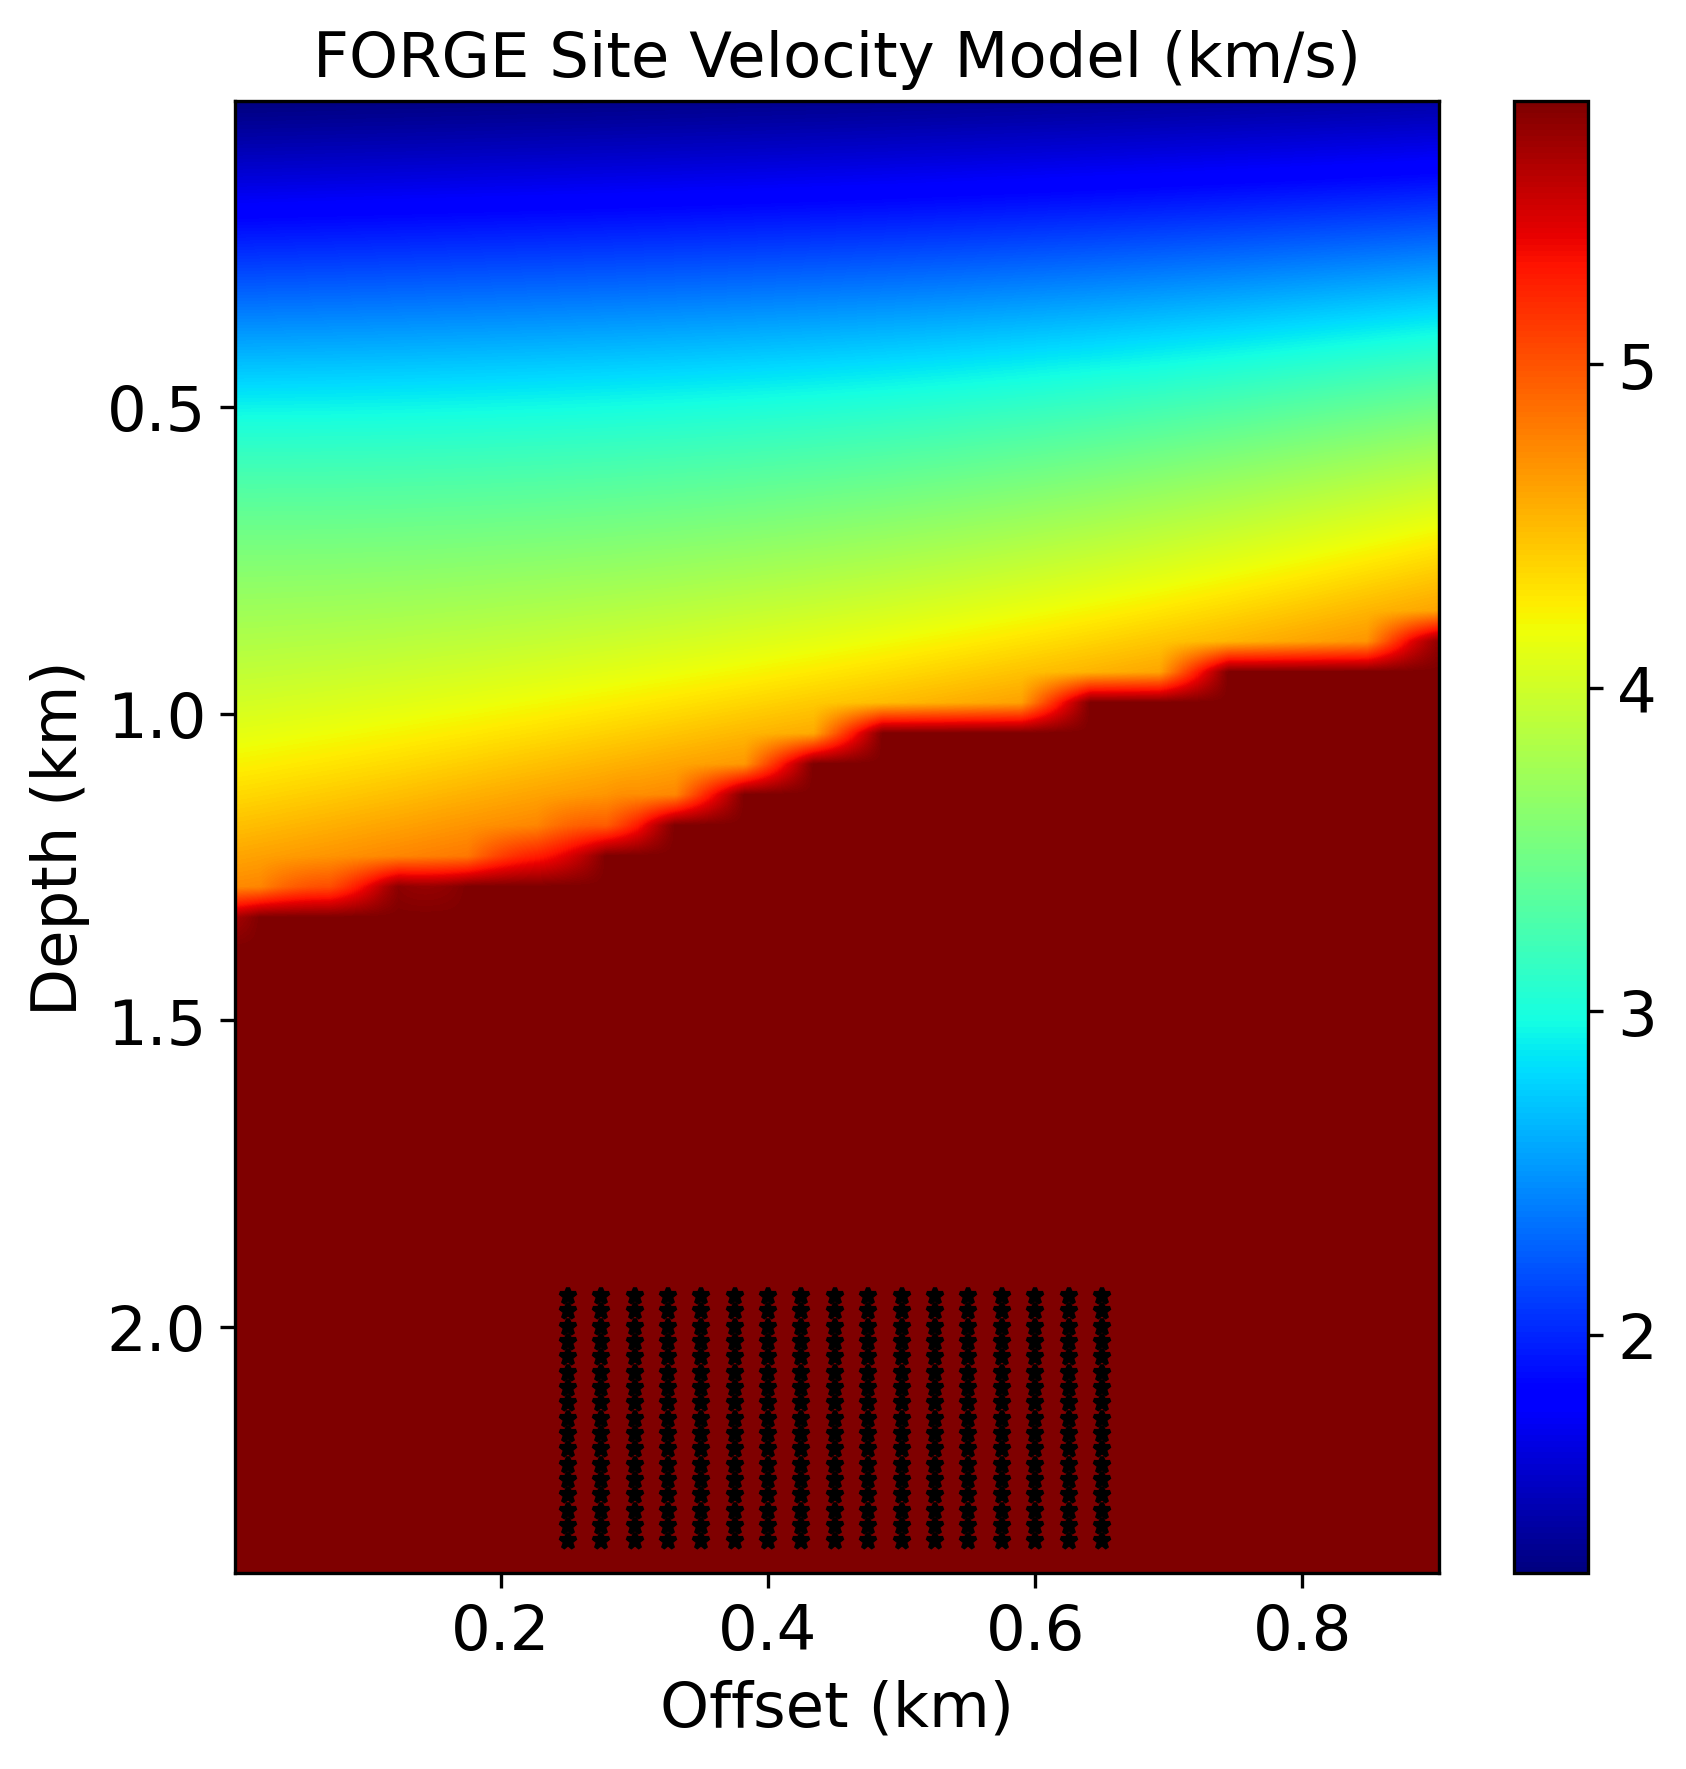

In [4]:
# Plot the velocity model with the source locations

fsize = 15

plt.figure( figsize = (6, 6), dpi=300 )

im = plt.imshow(velmodel/1000, cmap='jet',aspect='auto', extent=[XMIN/1000, XMAX/1000, YMAX/1000, YMIN/1000])

# Add a colorbar
cbar = plt.colorbar(im)
cbar.ax.tick_params(labelsize=fsize)

plt.plot(cord_x/1000, cord_z/1000, 'k*', markersize=4)

# Add labels and title
plt.xlabel('Offset (km)',size = fsize)
plt.ylabel('Depth (km)',size = fsize)
plt.title('FORGE Site Velocity Model (km/s)',size = fsize)

plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)

plt.tight_layout()

# plt.savefig( 'forge_velmodel.pdf' , dpi=300 )

plt.show()

In [6]:
# Generate train set with traveltime solutions

deltax = new_spacing
deltaz = new_spacing

y_train = np.zeros([ num_of_data, nz, nx ])

count = 0 

while count <= (num_of_data-1):
    for i in range(len(sz)):
        for j in range(len(sx)):
            
            phi = np.ones_like(velmodel)
            phi[np.round((cord_z[i][j])/deltaz).astype(int),
                np.round(cord_x[i][j]/deltax).astype(int)] = -1

            y_train[count,:,:] = skfmm.travel_time( phi, velmodel, dx=(deltaz,deltax), order=2 )            
            
            count = count + 1
            
        print( count )

17
34
51
68
85
102
119
136
153
170
187
204
221
238
255
272
289


In [ ]:
# Specify the file name

# y_train_name = '25m'+'_Tdata_y'+'_forge'+'.pkl'

# print(y_train_name)

In [11]:
# Save the fmm generated training set to use later

# import pickle

# Save the tensors using pickle directly, specifying protocol 4
# with open(y_train_name, 'wb') as f:
#     pickle.dump(y_train, f, protocol=4)

In [11]:
# Load the fmm generated training set if available

# import pickle

# Open the file in binary mode and load using protocol 4   
# with open(y_train_name, 'rb') as file:
#     y_train = pickle.load(file)

In [7]:
# Generate test set with traveltime solutions

size_of_data_set = 30

cord_z_test = np.random.randint( 1950, 2350, size=(size_of_data_set) )
cord_x_test = np.random.randint( 250, 650, size=(size_of_data_set) )

y_test = np.zeros([ size_of_data_set, nz, nx ])

count = 0 

while count < (size_of_data_set-1):
    for i in range(size_of_data_set):
        
            phi = np.ones_like(velmodel)
            phi[np.round((cord_z_test[i])/deltaz).astype(int),
                np.round(cord_x_test[i]/deltax).astype(int)] = -1

            y_test[count,:,:] = skfmm.travel_time(phi,velmodel,dx=(deltaz,deltax),order=2)
                        
            count = count + 1
            

In [8]:
rhs_input_train = y_train[:,:,-1].copy()
rhs_input_test = y_test[:,:,-1].copy()

In [9]:
for i in range(len(rhs_input_train)):      
    
    rhs_input_train[i][:195] = rhs_input_train[i][195]
    rhs_input_train[i][955:] = rhs_input_train[i][955]

for i in range(len(rhs_input_test)):      
    
    rhs_input_test[i][:195] = rhs_input_test[i][195]
    rhs_input_test[i][955:] = rhs_input_test[i][955]
    

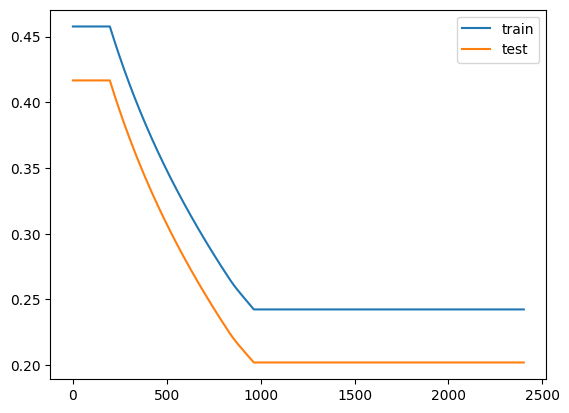

In [10]:
plt.plot(new_depth,rhs_input_train[-1], label='train' )
plt.plot(new_depth,rhs_input_test[-1], label='test' )

plt.legend()
plt.show()

In [11]:
rhs_input_train = rhs_input_train.reshape( num_of_data, nz, 1 )
rhs_input_test = rhs_input_test.reshape( size_of_data_set, nz, 1 )

In [12]:
x_train = np.repeat( rhs_input_train, nx, axis = 2 )
x_test = np.repeat( rhs_input_test, nx, axis = 2 )

In [13]:
x_test = torch.from_numpy(x_test)
y_test = torch.from_numpy(y_test)

x_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train)

In [14]:
x_train = x_train.reshape( len(x_train), nz, nx, 1 )
x_test = x_test.reshape( len(x_test), nz, nx, 1 )

In [15]:
print(f'Input size of training data: {np.shape(x_train)}')
print(f'Input size of testing data: {np.shape(x_test)}')

print('--'*50)

print(f'output size of training data: {np.shape(y_train)}')
print(f'output size of testing data: {np.shape(y_test)}')

Input size of training data: torch.Size([289, 2381, 894, 1])
Input size of testing data: torch.Size([30, 2381, 894, 1])
----------------------------------------------------------------------------------------------------
output size of training data: torch.Size([289, 2381, 894])
output size of testing data: torch.Size([30, 2381, 894])


In [16]:
x_test = x_test.type('torch.FloatTensor')
y_test = y_test.type('torch.FloatTensor')
y_train =  y_train.type('torch.FloatTensor')
x_train = x_train.type('torch.FloatTensor')

In [17]:
batch_size = 1

train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

In [18]:
class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels,  x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        #Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x

class FNO2d(nn.Module):
    def __init__(self, modes1, modes2,  width):
        super(FNO2d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the coefficient function and locations (a(x, y), x, y)
        input shape: (batchsize, x=s, y=s, c=3)
        output: the solution 
        output shape: (batchsize, x=s, y=s, c=1)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.padding = 9 # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(3, self.width) # input channel is 3: (a(x, y), x, y)

        self.conv0 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.w3 = nn.Conv2d(self.width, self.width, 1)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)
    
    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)
        x = F.pad(x, [0,self.padding, 0,self.padding])

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2

        x = x[..., :-self.padding, :-self.padding]
        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x
    
    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[1], shape[2]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1).to(device)

In [19]:
modes = 12
width = 24

model = FNO2d(modes, modes, width).cuda()

In [20]:
# Loss function with rel/abs Lp loss

class LpLoss(object):
    def __init__(self, d=2, p=2, size_average=True, reduction=True):
        super(LpLoss, self).__init__()

        #Dimension and Lp-norm type are postive
        assert d > 0 and p > 0

        self.d = d
        self.p = p
        self.reduction = reduction
        self.size_average = size_average

    def abs(self, x, y):
        num_examples = x.size()[0]

        #Assume uniform mesh
        h = 1.0 / (x.size()[1] - 1.0)

        all_norms = (h**(self.d/self.p))*torch.norm(x.view(num_examples,-1) - y.view(num_examples,-1), self.p, 1)

        if self.reduction:
            if self.size_average:
                return torch.mean(all_norms)
            else:
                return torch.sum(all_norms)

        return all_norms

    def rel(self, x, y):
        num_examples = x.size()[0]

        diff_norms = torch.norm(x.reshape(num_examples,-1) - y.reshape(num_examples,-1), self.p, 1)
        y_norms = torch.norm(y.reshape(num_examples,-1), self.p, 1)

        if self.reduction:
            if self.size_average:
                return torch.mean(diff_norms/y_norms)
            else:
                return torch.sum(diff_norms/y_norms)

        return diff_norms/y_norms

    def __call__(self, x, y):
        return self.rel(x, y)

In [21]:
learning_rate = 1e-3

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=10, verbose=True)

myloss = LpLoss(size_average=False)

patience = 50  # Number of epochs to wait before stopping

In [22]:
# To save the model

model_name = 'Model_forge_'+str(int(spacing))+'m_train_m'+str(modes)+'w'+str(width)+'_best.pt'

model_name

'Model_forge_25m_train_m12w24_best.pt'

In [ ]:
# Model training

start_training = default_timer()

epochs = 1000

train_loss = torch.zeros(epochs)
test_loss = torch.zeros(epochs)
best_val_loss = float('inf')
trigger_times = 0  # Counter for early stopping

for ep in tqdm(range(1,epochs+1)):
    
    model.train()
    t1 = default_timer()
    train_l2 = 0
    
    for x, y in train_loader:
        
        x, y = x.cuda(), y.cuda()

        optimizer.zero_grad()
        out = model(x).reshape(batch_size, nz, nx)

        loss = myloss(out.view(batch_size,-1), y.view(batch_size,-1)) 
        loss.backward()
        
        optimizer.step()        
        train_l2 += loss.item()

    train_l2 /= len(x_train)
    train_loss[ep-1] = train_l2
    
    scheduler.step( train_l2 ) # Update learning rate with average of train events

    # Early stopping logic
    if train_l2 < best_val_loss:
        
        best_val_loss = train_l2
        trigger_times = 0  # Reset the counter if validation loss improves
        
        # Optionally, save the model with the best validation loss
        torch.save( model.state_dict(), model_name )
        
    else:
        
        trigger_times += 1
        
        if trigger_times >= patience:
            
            print(f"Early stopping at epoch {ep}")
            break  # Stop training if validation loss hasn't improved in 'patience' epochs


    
    model.eval()    
    test_l2 = 0.0
      
    with torch.no_grad():
        
        for x, y in test_loader:
            
            x, y = x.cuda(), y.cuda()

            out = model(x).reshape( batch_size, nz, nx )

            test_l2 += myloss(out.view(batch_size,-1), y.view(batch_size,-1)).item()
        
    test_l2 /= len(x_test)    
    test_loss[ep-1] = test_l2
    
    t2 = default_timer()
    print(f'Epoch:{ep} \n Training time for  epoch {ep}: {round((t2-t1)/60,3)} minutes,Training loss:  {train_l2}, Testing loss: {test_l2}')

    if (ep+1) % 10 == 0:

        # Loss Figure
        fig = plt.figure(figsize=(5, 3), dpi=300)
        ax = plt.axes()
            
        ax.semilogy( test_loss[:ep], linewidth=2, label = 'Test loss')
        ax.semilogy( train_loss[:ep], linewidth=2, label = 'Training loss', color = 'orange')
        ax.set_xlabel('Epochs', fontsize=10)
        plt.xticks(fontsize=10)
        ax.xaxis.set_major_locator(plt.MultipleLocator(100))        
        ax.set_ylabel('Loss', fontsize=10)
        plt.yticks(fontsize=10)
        plt.grid()
        plt.legend(loc='upper right')
        plt.title('Comparison of Training and test losses')
        plt.show()

end = default_timer() - start_training

if end > 3600:
    print(f'Total training time {round(end/3600,3)} hours')
else:
    print(f'Total training time {round(end/60,3)} minutes')

In [ ]:
# Convergence history plot for verification

plt.style.use('default')
fig = plt.figure(figsize=(5, 3), dpi=600)
ax = plt.axes()

ax.semilogy(test_loss[:ep], linewidth=2, label = 'Test loss')
ax.semilogy(train_loss[:ep], linewidth=2, label = 'Training loss', color = 'orange')

ax.set_xlabel('Epochs', fontsize=12)
plt.xticks(fontsize=12)
ax.xaxis.set_major_locator(plt.MultipleLocator(200))

ax.set_ylabel('Loss', fontsize=12)
plt.yticks(fontsize=12)

plt.grid()
plt.legend(loc='upper right')
plt.title('Comparison of Training and test losses')

plt.tight_layout()

# plt.savefig( 'Loss_forge_'+str(int(spacing))+'m_m12w24.png' , dpi=600 )

plt.show()

In [25]:
# To load the model if available

# model_name = 'Model_forge_25m_m12w24_best.pt'

# model.load_state_dict(torch.load(model_name))

model.eval()  

FNO2d(
  (fc0): Linear(in_features=3, out_features=24, bias=True)
  (conv0): SpectralConv2d()
  (conv1): SpectralConv2d()
  (conv2): SpectralConv2d()
  (conv3): SpectralConv2d()
  (w0): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1))
  (w1): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1))
  (w2): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1))
  (w3): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1))
  (fc1): Linear(in_features=24, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)

In [26]:
fsize = 12

def cust_pcolor(AX, X, Y, P, Xs=None, Ys=None, title=None, cmap='jet', 
                xlabel=True, ylabel=False, vmin=None, vmax=None):
    
    ax1 = AX.pcolor(X, Y, P, cmap=cmap, vmin=vmin, vmax=vmax)
    
    cbar = plt.colorbar(ax1, ax=AX)
    cbar.ax.tick_params(labelsize=fsize)
    
    if Xs and Ys:
        AX.scatter(Xs, Ys, marker='*', color='r', s = 100 )
        
    AX.set_title(title, size=fsize)

    AX.invert_yaxis()
    
    AX.xaxis.set_major_locator(plt.MultipleLocator(0.5))

    AX.tick_params(axis='both', which='major', labelsize=fsize )  # Set tick label fontsize
    
    if xlabel: AX.set_xlabel('Offset (km)', size=fsize)
    if ylabel: AX.set_ylabel('Depth (km)', size=fsize)

    AX.set_aspect(1)

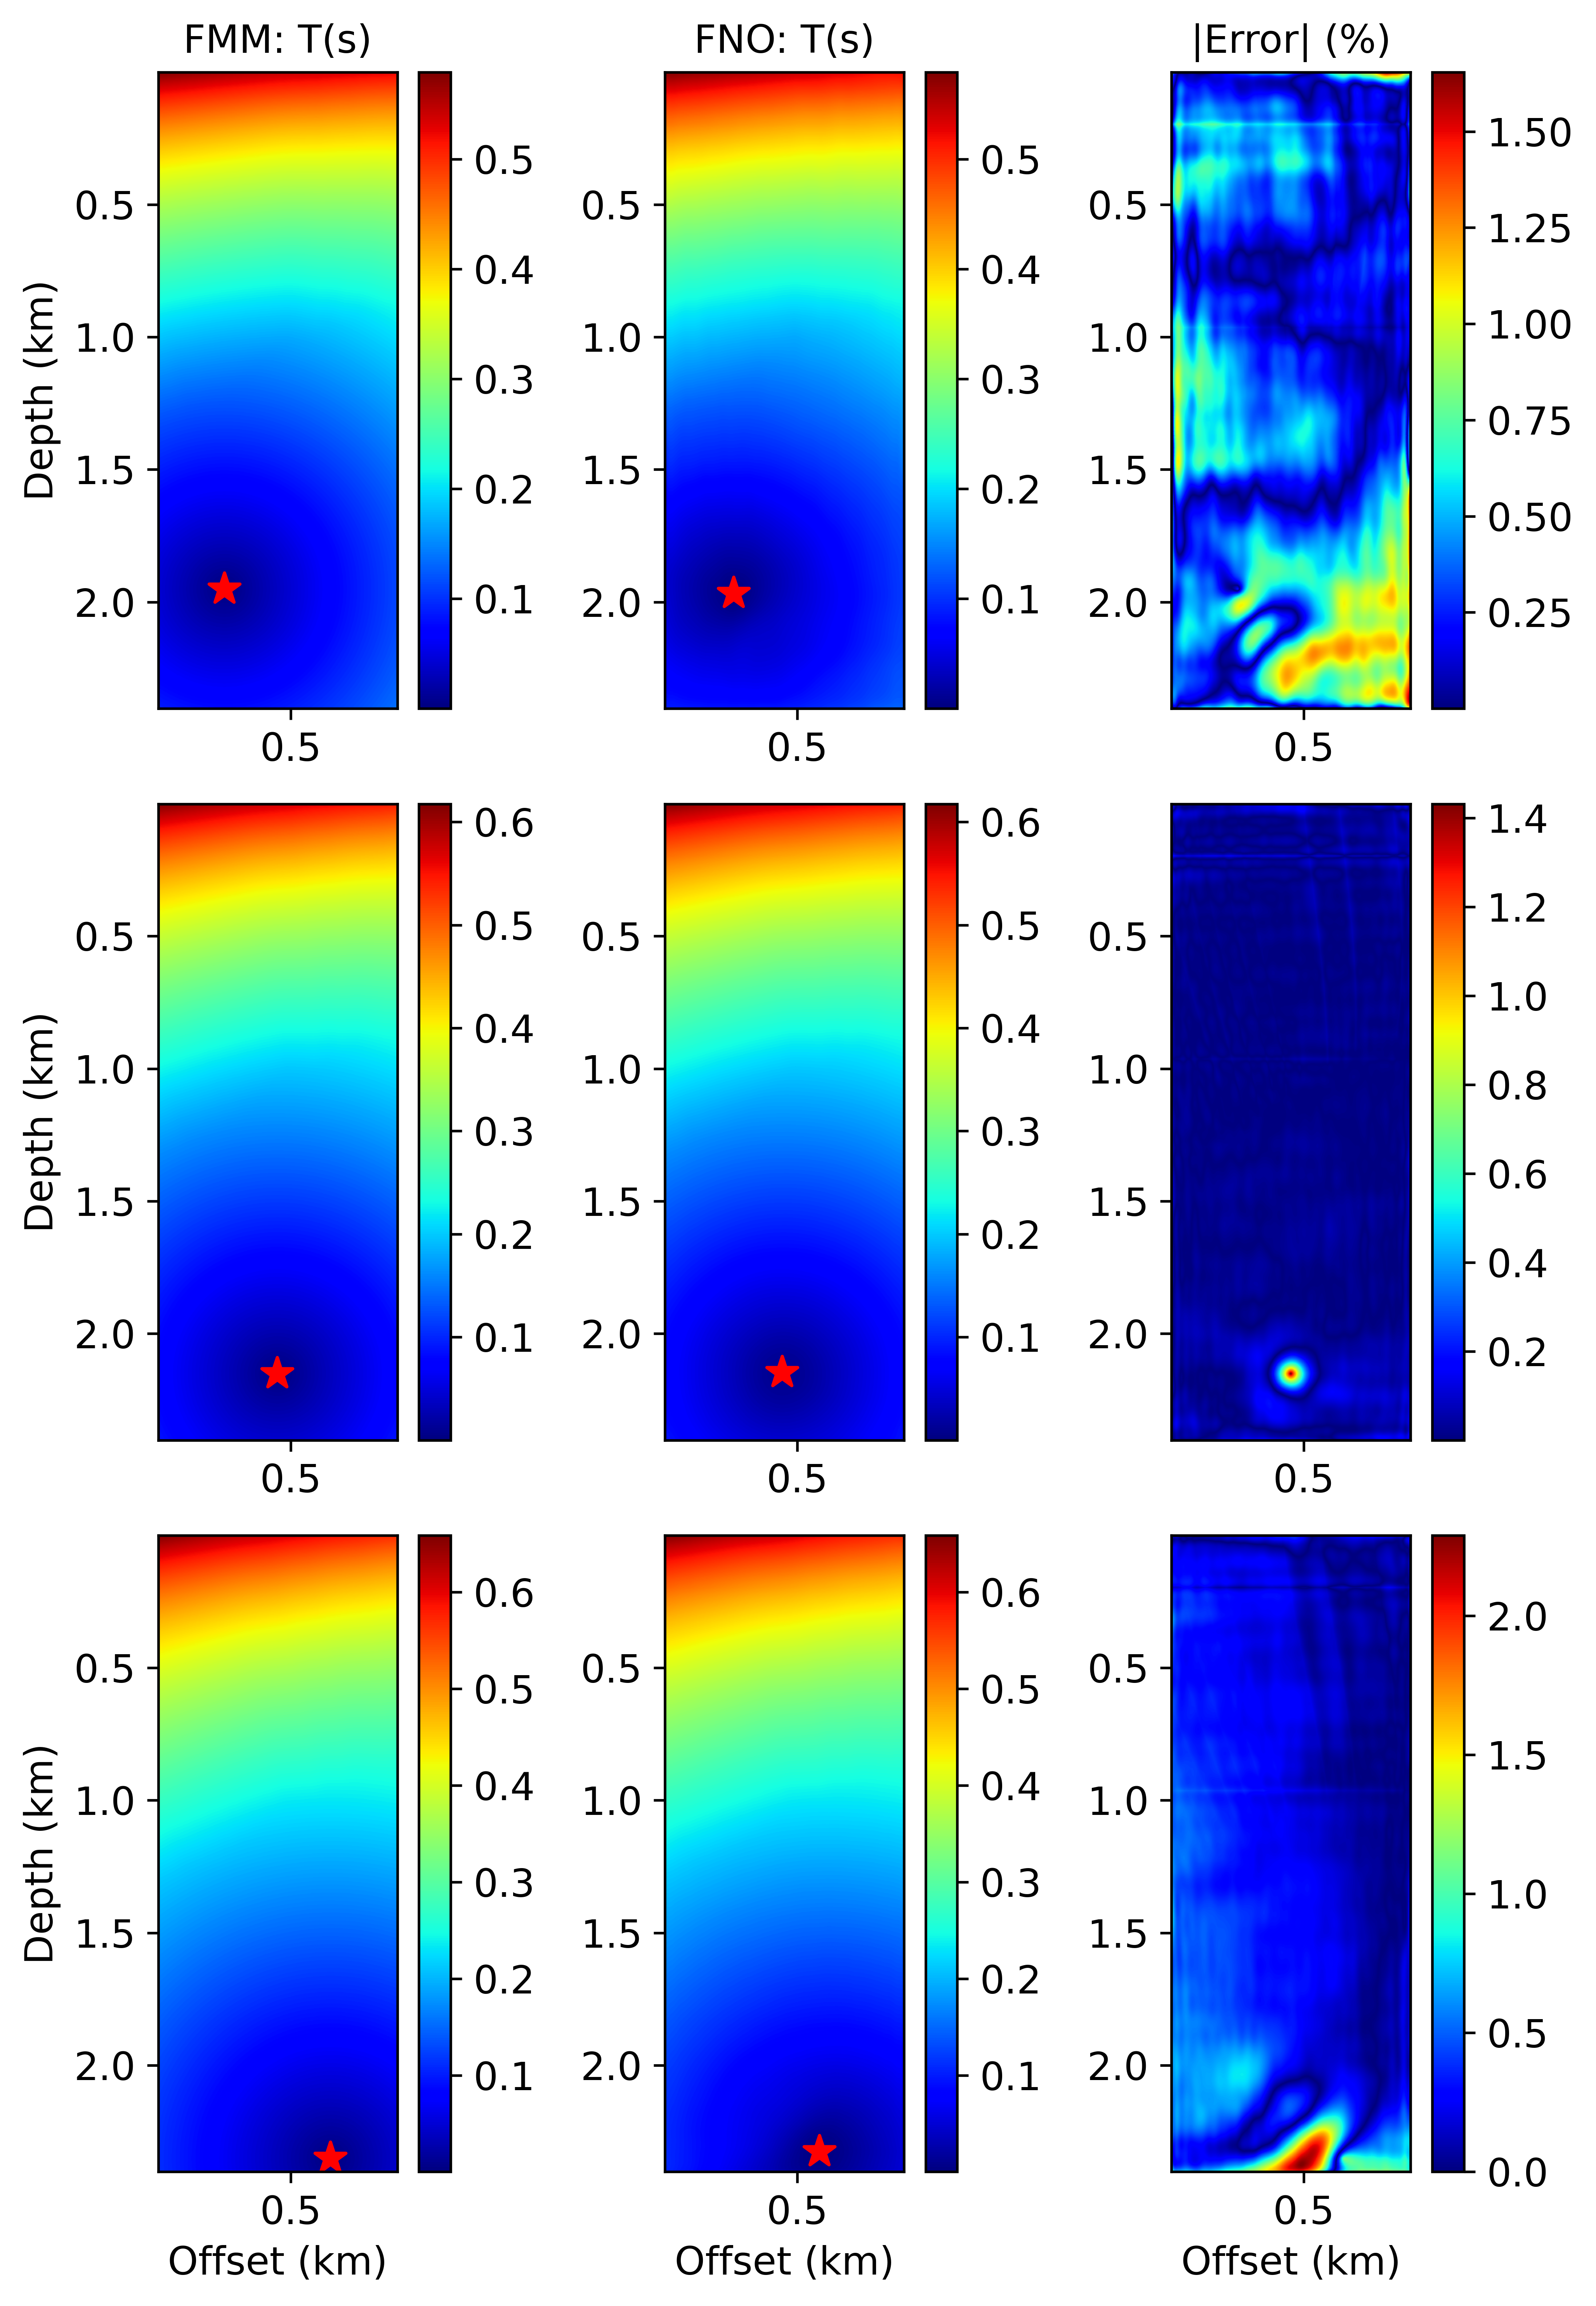

In [27]:
fig, ax = plt.subplots(3, 3, figsize=(7, 10), dpi = 600 )

x_test = XGRID.T/1000
y_test = YGRID.T/1000
batch_size = 1

for i, (xi, eta) in enumerate([(250, 1950), (450, 2150), (650, 2350)]):

    T_data_y_syn = np.zeros([nz,nx])
    phi = np.ones_like(velmodel)
    phi[np.round(eta/new_spacing).astype(int),
        np.round(xi/new_spacing).astype(int)] = -1
    T_data_y_syn[:,:] = skfmm.travel_time(phi,velmodel,dx=(deltaz, deltax),order=2)
    
    rhs_input_syn = T_data_y_syn[:,-1].copy()
    T_syn = rhs_input_syn[195:956].copy()
    test_flat = np.zeros( nz )
    test_flat[:195] = T_syn[0]
    test_flat[195:956] = T_syn.copy()
    test_flat[956:] = T_syn[-1]

    perfshot_obs = test_flat.reshape( 1,nz,1 )
    perfshot_obs = np.repeat( perfshot_obs,nx,axis = 2 )    
    perfshot_obs = torch.from_numpy( perfshot_obs )    
    perfshot_obs = perfshot_obs.reshape( 1,nz,nx,1 )            
    perfshot_obs = perfshot_obs.type( 'torch.FloatTensor' )            
    perfshot_obs = perfshot_obs.cuda()
        
    out = model(perfshot_obs).reshape(batch_size, nz, nx)
    pred = out.cpu()
    pred = pred.reshape(nz, nx)    
    ssz, ssx = np.where(pred == torch.min(pred))            
    ss = ( deltax*ssx[0], deltaz*ssz[0] )
    
    exact = T_data_y_syn.copy()
    x_source = xi/1000
    y_source = eta/1000
    
    pred = pred.detach().numpy()
    x_source_pred = ss[0]/1000
    y_source_pred = ss[1]/1000

    cust_pcolor(ax[i, 0], x_test, y_test, exact, x_source, y_source, 'FMM: T(s)' if i==0 else None, 
                cmap='jet', vmin=exact.min(), vmax=exact.max(), ylabel=True, xlabel=True if i==2 else False)
    cust_pcolor(ax[i, 1], x_test, y_test, pred, x_source_pred, y_source_pred, 'FNO: T(s)' if i==0 else None,
                'jet', vmin=exact.min(), vmax=exact.max(), xlabel=True if i==2 else False)
    
    error = abs(pred - exact) / exact.max() * 100
    cust_pcolor(ax[i, 2], x_test, y_test, error, title='|Error| (%)' if i==0 else None,
                cmap='jet', xlabel=True if i==2 else False)

plt.tight_layout()

# plt.savefig( 'forge_preds-pub_'+str(int(spacing))+'m_m12w24.png' , dpi=600 )

plt.show()

In [28]:
# Specify the file names

T_data_y_test_name = '1000'+'_y_test'+'_forge_25m'+'.pkl'
cord_test_name = '1000'+'_cord_test'+'_forge_25m'+'.pt'

print(T_data_y_test_name)
print(cord_test_name)

1000_y_test_forge_25m.pkl
1000_cord_test_forge_25m.pt


In [16]:
# Load the fmm generated testing set if available

# cord_test = torch.load(cord_test_name)
# cord_z_test = cord_test[1]
# cord_x_test = cord_test[0]

# import pickle

# # Open the file in binary mode and load using protocol 4   
# with open(T_data_y_test_name, 'rb') as file:
#     T_data_y_test = pickle.load(file)

In [29]:
# Generate test set 

cord_z_test = np.random.randint( 1950, 2350, size=(1000) )
cord_x_test = np.random.randint( 250, 650, size=(1000) )

T_data_y_test = np.zeros([ len(cord_z_test), nz, nx ])

count = 0 
rmse_error = []
source_error = []

while count < (len(cord_z_test)-1):
    for i in range(len(cord_z_test)):
        
            phi = np.ones_like(velmodel)
            phi[np.round((cord_z_test[i])/deltaz).astype(int),
               np.round(cord_x_test[i]/deltax).astype(int)] = -1            
            T_data_y_test[count,:,:] = skfmm.travel_time(phi,velmodel,dx=(deltaz,deltax),order=2)

            rhs_input_syn = T_data_y_test[count,:,-1].copy()
            T_syn = rhs_input_syn[195:956].copy()
            test_flat = np.zeros( nz )
            test_flat[:195] = T_syn[0]
            test_flat[195:956] = T_syn.copy()
            test_flat[956:] = T_syn[-1]
        
            perfshot_obs = test_flat.reshape( 1,nz,1 )
            perfshot_obs = np.repeat( perfshot_obs,nx,axis = 2 )    
            perfshot_obs = torch.from_numpy( perfshot_obs )    
            perfshot_obs = perfshot_obs.reshape( 1,nz,nx,1 )            
            perfshot_obs = perfshot_obs.type( 'torch.FloatTensor' )            
            perfshot_obs = perfshot_obs.cuda()
                    
            out = model(perfshot_obs).reshape(batch_size, nz, nx)
            pred = out.cpu()
            pred = pred.reshape(nz, nx)    
            ssz, ssx = np.where(pred == torch.min(pred))
            ss = ( deltax*ssx[0], deltaz*ssz[0] )

            exact = T_data_y_test[count,:,:].copy()
            x_source = cord_x_test[i]
            y_source = cord_z_test[i]
            
            pred = pred.detach().numpy()
            x_source_pred = ss[0]
            y_source_pred = ss[1]

            rmse_error.append( np.sqrt( np.mean( ( exact - pred )**2 ) ) )
            source_error.append( [ x_source-x_source_pred, y_source-y_source_pred ] )
            
            count = count + 1            
            print( count )

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [100]:
# Save the fmm generated testing set to use later

# cord_test = [cord_x_test, cord_z_test]
# torch.save(cord_test,cord_test_name)

# import pickle

# Save the tensors using pickle directly, specifying protocol 4
# with open(T_data_y_test_name, 'wb') as f:
#    pickle.dump(T_data_y_test, f, protocol=4)

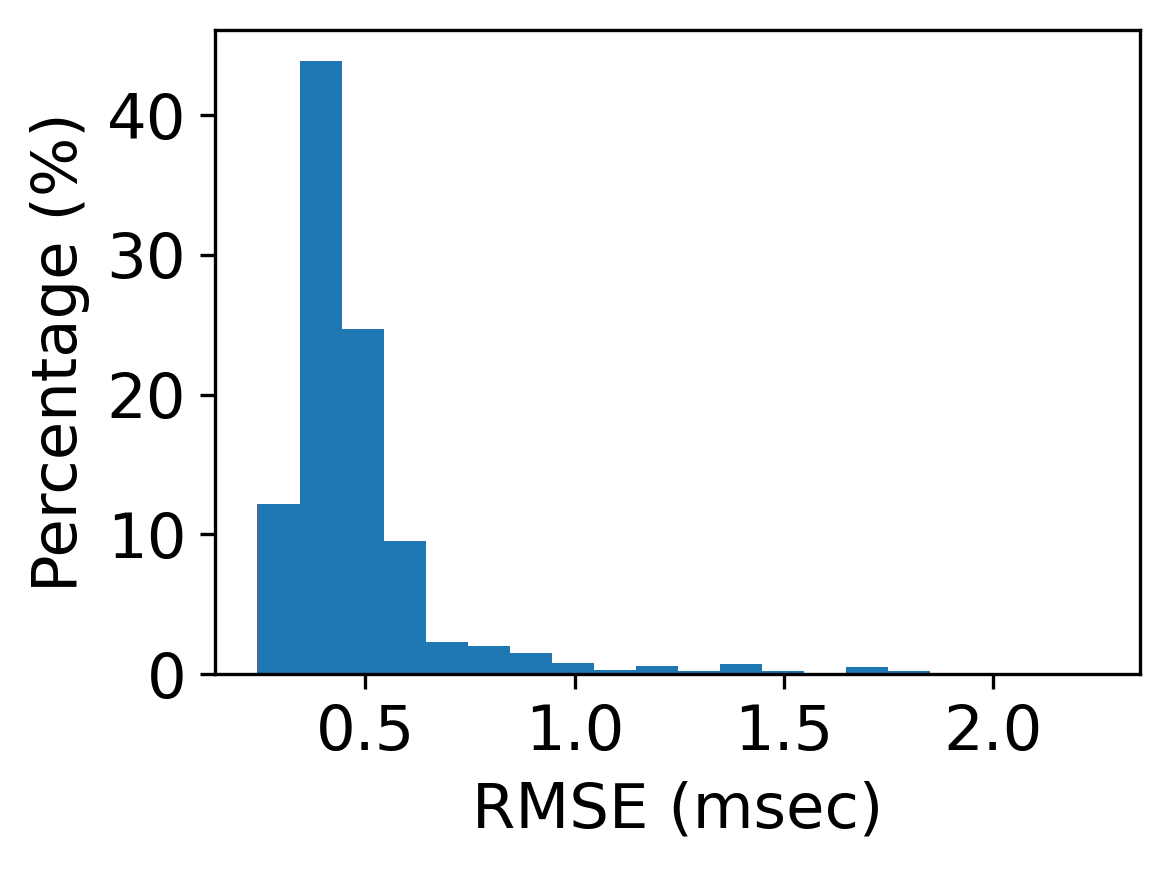

In [30]:
fsize = 15

rmse_error = np.array(rmse_error)
weights = np.ones(len(rmse_error)) / len(rmse_error) * 100

plt.figure( figsize=(4,3), dpi = 300 )

plt.hist(rmse_error*1000, 20, weights=weights)

plt.xlabel('RMSE (msec)',fontsize=fsize)
plt.ylabel('Percentage (%)',fontsize=fsize)

plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)

plt.tight_layout()

# plt.savefig( 'forge_RMSE_1000_'+str(int(spacing))+'m_m12w24.pdf' , dpi=300 )

plt.show()

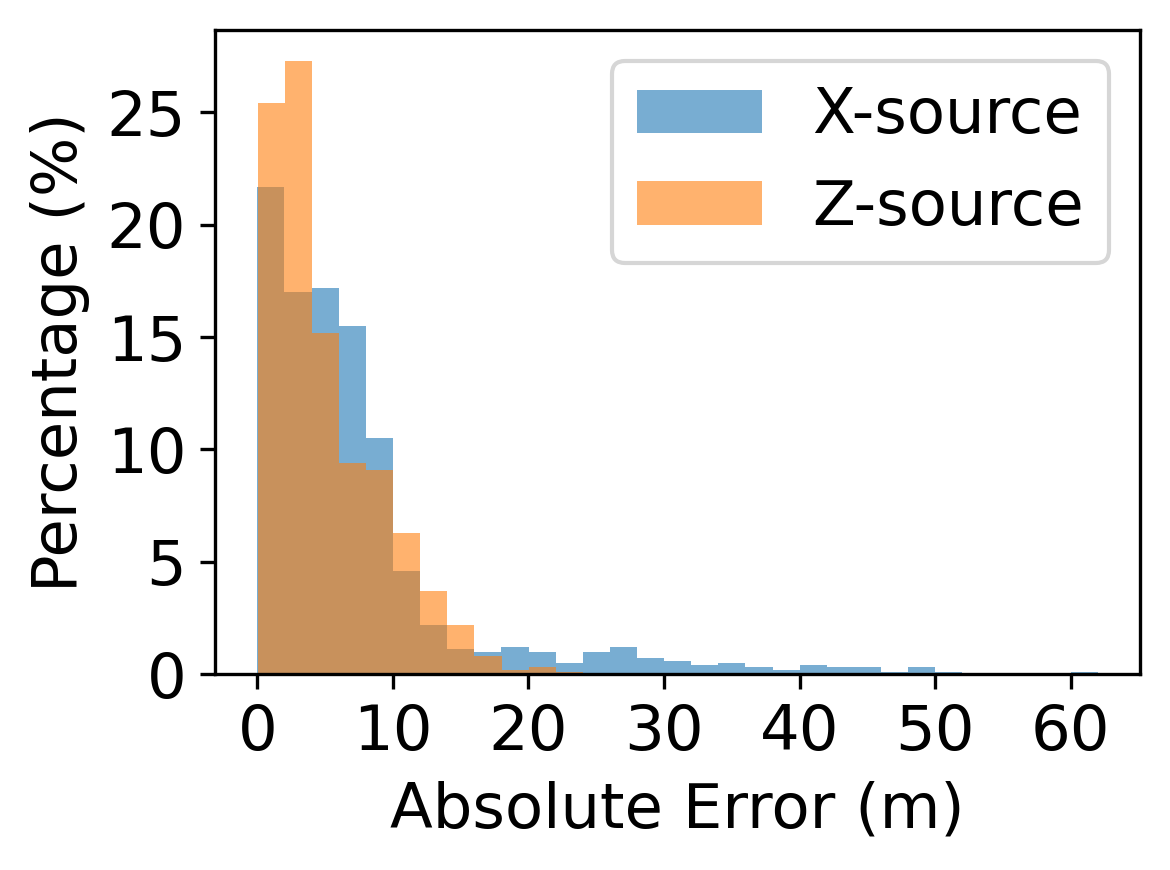

In [31]:
fsize = 15

weights = np.ones(len(rmse_error)) / len(rmse_error) * 100
source_error = np.array(source_error)

fig, ax = plt.subplots(1, 1, figsize=(4,3), dpi=300 )
ax = [ax]

# Desired bin width
bin_width = 2 # meters

for i in range(2) :

    data = abs(source_error[:, i])
    
    # Define bin edges with a width of 2 meters
    bin_edges = np.arange( min(data), max(data) + bin_width, bin_width )

    # Create the histogram with exact bin edges
    ax[0].hist( data, bins=bin_edges, weights=weights, alpha=0.6 )

ax[0].set_xlabel('Absolute Error (m)',fontsize=fsize)
ax[0].set_ylabel('Percentage (%)',fontsize=fsize)

plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)

plt.tight_layout()
plt.legend( ['X-source', 'Z-source'], fontsize=fsize )

# plt.savefig( 'forge_abs_errors_1000_'+str(int(spacing))+'m_m12w24.pdf' , dpi=300 )

plt.show()

FINE-TUNING FNO MODEL WITH REAL EVENT DATA

In [32]:
# Computing traveltimes for the reference point used for normalizing observed traveltimes

T_data_y_syn = np.zeros([ nz, nx ])
phi = np.ones_like(velmodel)
phi[np.round( 2150 / new_spacing ).astype(int),
    np.round( 450 / new_spacing ).astype(int)] = -1
T_data_y_syn[:,:] = skfmm.travel_time( phi,velmodel,dx=(new_spacing,new_spacing),order=2 )
T_syn = T_data_y_syn[195:956,-1].copy()

In [33]:
# Picked event coordinates from the FORGE catalog

event_cord = np.zeros( (15,3) )

event_cord[0] = [335349.9, 4263108.1,	1687.373-2126]

event_cord[1] = [335371.85,	4263060.26,	-469.87]

event_cord[2] = [335344.02,	4263083.03,	-442.15]

event_cord[3] = [335385.73,	4263057.83,	-448.45]

event_cord[4] = [335349.9,	4263108.1,	-410.96]

event_cord[5] = [335419.14,	4263078.09,	-476.71]

event_cord[6] = [335359.29,	4263086.58,	-449.84]

event_cord[7] = [335349.7,	4263077.43,	-459]

event_cord[8] = [335385.27,	4263051.81,	-427.54]

event_cord[9] = [335380,	4263068.02,	-485.67]

event_cord[10] = [335400.27,	4263074,	-441.09]

event_cord[11] = [335396.71,	4263049.08,	-450.83]

event_cord[12] = [335358.68,	4263064.42,	-470.82]

event_cord[13] = [335381.74,	4263128.96,	-384.97]

event_cord[14] = [335379.38,	4263151.04,	-398.88]


In [34]:
# Function to compute horizontal distance with the monitoring well 78-32

def calc_horizontal( x1, y1 ):

    well_x = 335780.8409   # well head 78-32 verified Excel file Well trajectories
    well_y = 4262991.988   # well head 78-32 verified Excel file Well trajectories
    
    x = (well_x - x1)**2
    y = (well_y - y1)**2
    
    distance = (x+y)**0.5
    
    return distance

In [35]:
# Event locations in the new 2D slice coordinate system

groundtruth_loc = np.zeros( (15, 2) )

for i in range(15) :

    groundtruth_loc[i,0] = 900 - calc_horizontal( event_cord[i,0],event_cord[i,1] )

    groundtruth_loc[i,1] = 1687.373 - event_cord[i,2]


In [37]:
from scipy.interpolate import interp1d

# Event ## for Training
train_idx = 0, 5, 9, 13

rhs_input_train = np.zeros( ( len(train_idx), nz ) )

for i in range( len(train_idx) ): 
        
    T_obs = pd.read_csv(f"./events_csv/event{train_idx[i]}.csv")
    T_obs = T_obs["Ptime"]
    T_obs = T_obs.values
    T_obs = T_obs[130:891]

    x_data = np.arange(130,891)
    y_data = T_obs

    # Identify the zero values
    zero_indices = np.where(y_data == 0)[0]

    # Filter out zero values (nonzero indices)
    nonzero_indices = np.nonzero(y_data)[0]
    x_nonzero = x_data[nonzero_indices]
    y_nonzero = y_data[nonzero_indices]
    
    # Create the interpolation function with linear interpolation
    interp_function = interp1d(x_nonzero, y_nonzero, kind='linear', fill_value='extrapolate')
    
    # Extrapolate for new x values
    x_extrap = x_data[zero_indices]
    y_extrap = interp_function(x_extrap)

    # Replace the zero values in y_data with the extrapolated values
    y_data[zero_indices] = y_extrap
    
    T_obs = np.flip(y_data) 
    
    T_obs = T_obs - np.min(T_obs) + np.min(T_syn)
         
    test_flat = np.zeros( nz )
    test_flat[:195] = T_obs[0]
    test_flat[195:956] = T_obs.copy()
    test_flat[956:] = T_obs[-1]

    rhs_input_train[i,:] = test_flat.copy()

In [38]:
from scipy.interpolate import interp1d

# Event ## for Testing
test_idx = np.arange(15)

rhs_input_test = np.zeros( ( len(test_idx), nz ) )

for i in range( len(test_idx) ): 

    T_obs = pd.read_csv(f"./events_csv/event{test_idx[i]}.csv")
    T_obs = T_obs["Ptime"]
    T_obs = T_obs.values
    T_obs = T_obs[130:891]

    x_data = np.arange(130,891)
    y_data = T_obs

    # Identify the zero values
    zero_indices = np.where(y_data == 0)[0]

    # Filter out zero values (nonzero indices)
    nonzero_indices = np.nonzero(y_data)[0]
    x_nonzero = x_data[nonzero_indices]
    y_nonzero = y_data[nonzero_indices]
    
    # Create the interpolation function with linear interpolation
    interp_function = interp1d(x_nonzero, y_nonzero, kind='linear', fill_value='extrapolate')
    
    # Extrapolate for new x values
    x_extrap = x_data[zero_indices]
    y_extrap = interp_function(x_extrap)

    # Replace the zero values in y_data with the extrapolated values
    y_data[zero_indices] = y_extrap
    
    T_obs = np.flip(y_data)
    
    T_obs = T_obs - np.min(T_obs) + np.min(T_syn)
          
    test_flat = np.zeros( nz )
    test_flat[:195] = T_obs[0]
    test_flat[195:956] = T_obs.copy()
    test_flat[956:] = T_obs[-1]

    rhs_input_test[i,:] = test_flat.copy()
    

In [39]:
rhs_input_train = rhs_input_train.reshape( len(train_idx), nz, 1 )
rhs_input_test = rhs_input_test.reshape( len(test_idx), nz, 1 )

x_train = np.repeat(rhs_input_train,nx,axis = 2)
x_test = np.repeat(rhs_input_test,nx,axis = 2)

In [40]:
y_train = np.zeros( ( len(train_idx), nz, nx ) )

for i in range( len(train_idx) ): 

    phi = np.ones_like(velmodel)
    phi[np.round( groundtruth_loc[train_idx[i]][1] / new_spacing ).astype(int),
        np.round( groundtruth_loc[train_idx[i]][0] / new_spacing ).astype(int)] = -1
    y_train[i,:,:] = skfmm.travel_time( phi,velmodel,dx=(new_spacing,new_spacing),order=2 )


In [41]:
y_test = np.zeros( ( len(test_idx), nz, nx ) )

for i in range( len(test_idx) ): 

    phi = np.ones_like(velmodel)
    phi[np.round( groundtruth_loc[test_idx[i]][1] / new_spacing ).astype(int),
        np.round( groundtruth_loc[test_idx[i]][0] / new_spacing ).astype(int)] = -1
    y_test[i,:,:] = skfmm.travel_time( phi,velmodel,dx=(new_spacing,new_spacing),order=2 )
    

In [42]:
x_test = torch.from_numpy(x_test)
y_test = torch.from_numpy(y_test)

x_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train)

In [43]:
x_train = x_train.reshape( len(x_train), nz, nx, 1 )
x_test = x_test.reshape( len(x_test), nz, nx, 1 )

In [44]:
print(f'Input size of training data: {np.shape(x_train)}')
print(f'Input size of testing data: {np.shape(x_test)}')

print('--'*50)

print(f'output size of training data: {np.shape(y_train)}')
print(f'output size of testing data: {np.shape(y_test)}')

Input size of training data: torch.Size([4, 2381, 894, 1])
Input size of testing data: torch.Size([15, 2381, 894, 1])
----------------------------------------------------------------------------------------------------
output size of training data: torch.Size([4, 2381, 894])
output size of testing data: torch.Size([15, 2381, 894])


In [45]:
x_test = x_test.type('torch.FloatTensor')
y_test = y_test.type('torch.FloatTensor')
y_train =  y_train.type('torch.FloatTensor')
x_train = x_train.type('torch.FloatTensor')

In [46]:
batch_size = 1

train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

In [73]:
learning_rate = 1e-3

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=10, verbose=True)

myloss = LpLoss(size_average=False)

patience = 100  # Number of epochs to wait before stopping


In [74]:
# Transfer Learning

model_name = 'Model_forge_25m_m12w24_best.pt'

model_name

'Model_forge_25m_m12w24_best.pt'

In [75]:
# Load the model

model.load_state_dict(torch.load(model_name))

<All keys matched successfully>

In [76]:
# To save the model

model_name = 'Model_forgeTL_25m_train_m12w24_best'+'.pt'

model_name

'Model_forgeTL_25m_train_m12w24_best.pt'

  5%|█▉                                       | 48/1000 [02:08<42:54,  2.70s/it]

Epoch 00049: reducing learning rate of group 0 to 8.0000e-04.
Epoch:49 
 Training time for  epoch 49: 0.045 minutes,Training loss:  0.02331281593069434, Testing loss: 0.024804741020003955


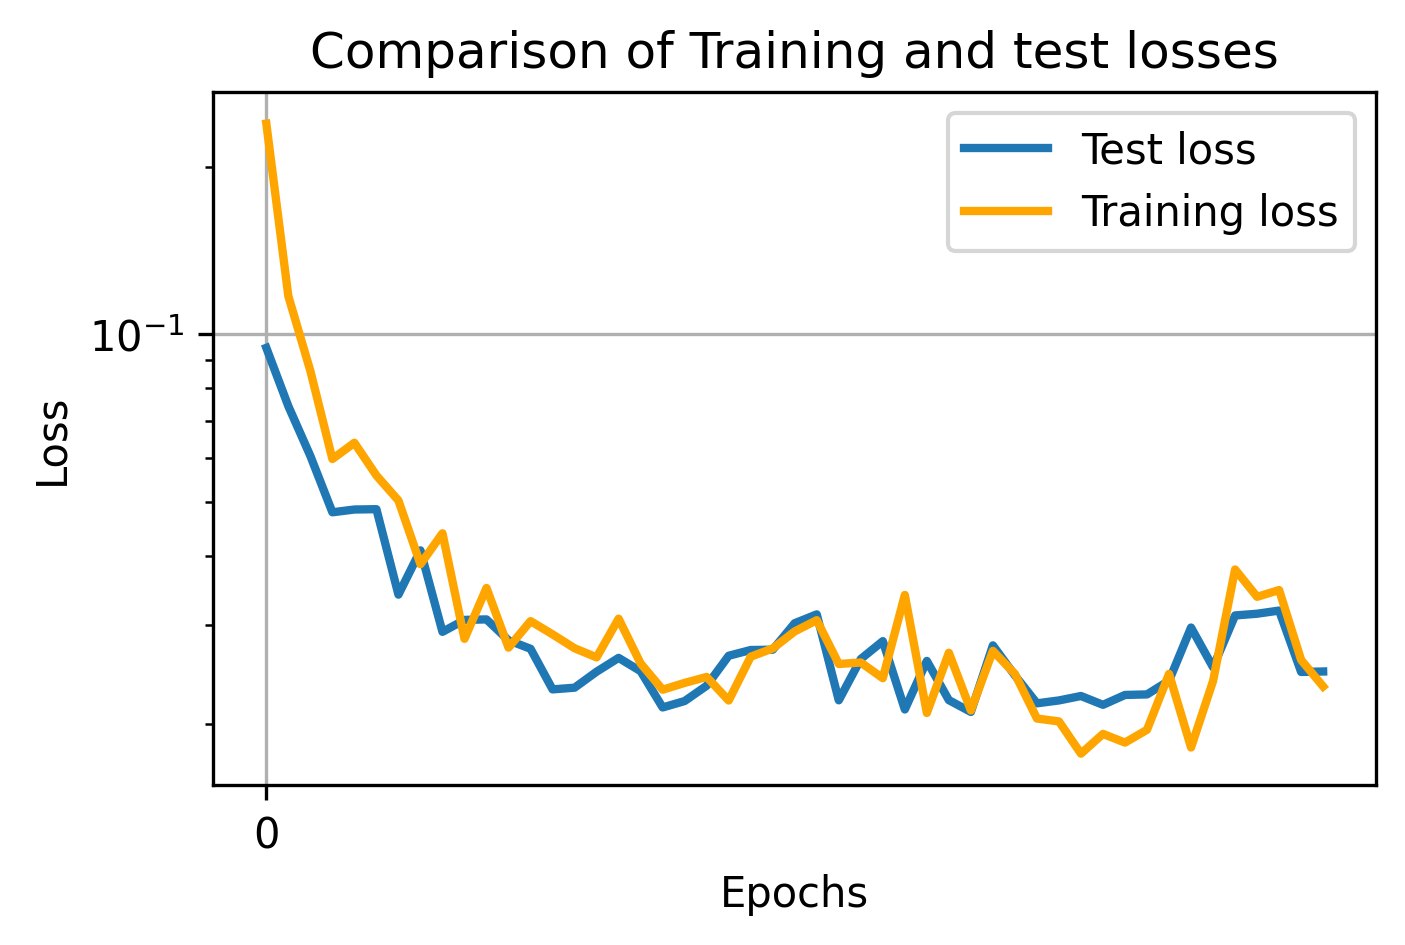

  8%|███                                      | 75/1000 [03:22<41:29,  2.69s/it]

Epoch 00076: reducing learning rate of group 0 to 6.4000e-04.


 10%|████                                     | 98/1000 [04:23<40:08,  2.67s/it]

Epoch:99 
 Training time for  epoch 99: 0.045 minutes,Training loss:  0.01021354307886213, Testing loss: 0.02008536718785763


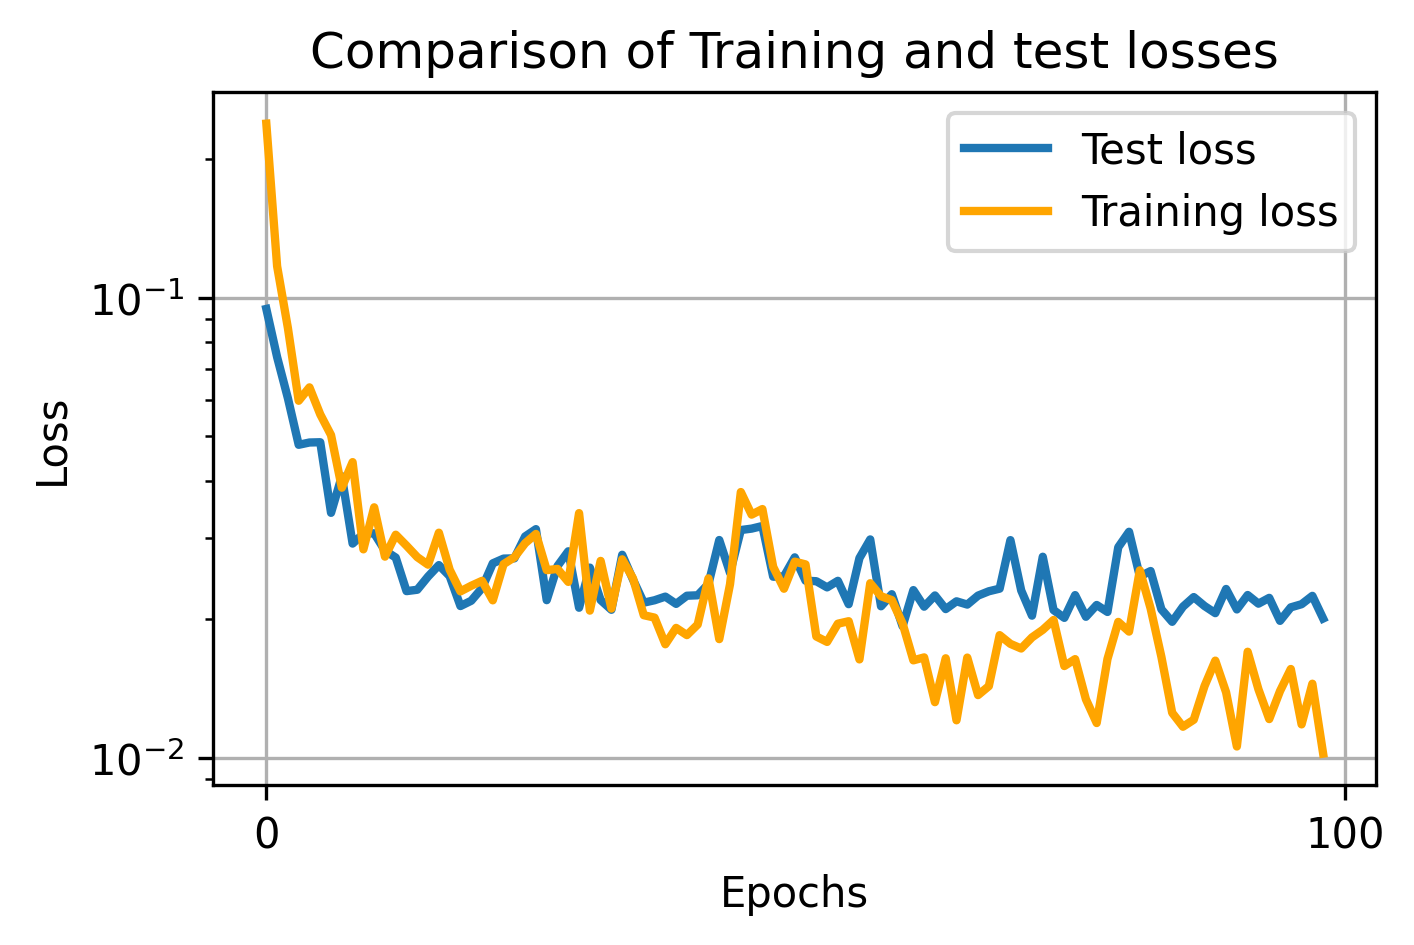

 11%|████▎                                   | 109/1000 [04:53<39:44,  2.68s/it]

Epoch 00110: reducing learning rate of group 0 to 5.1200e-04.


 14%|█████▌                                  | 138/1000 [06:10<38:24,  2.67s/it]

Epoch 00139: reducing learning rate of group 0 to 4.0960e-04.


 15%|█████▉                                  | 148/1000 [06:37<38:01,  2.68s/it]

Epoch:149 
 Training time for  epoch 149: 0.045 minutes,Training loss:  0.010505456710234284, Testing loss: 0.01922014366524915


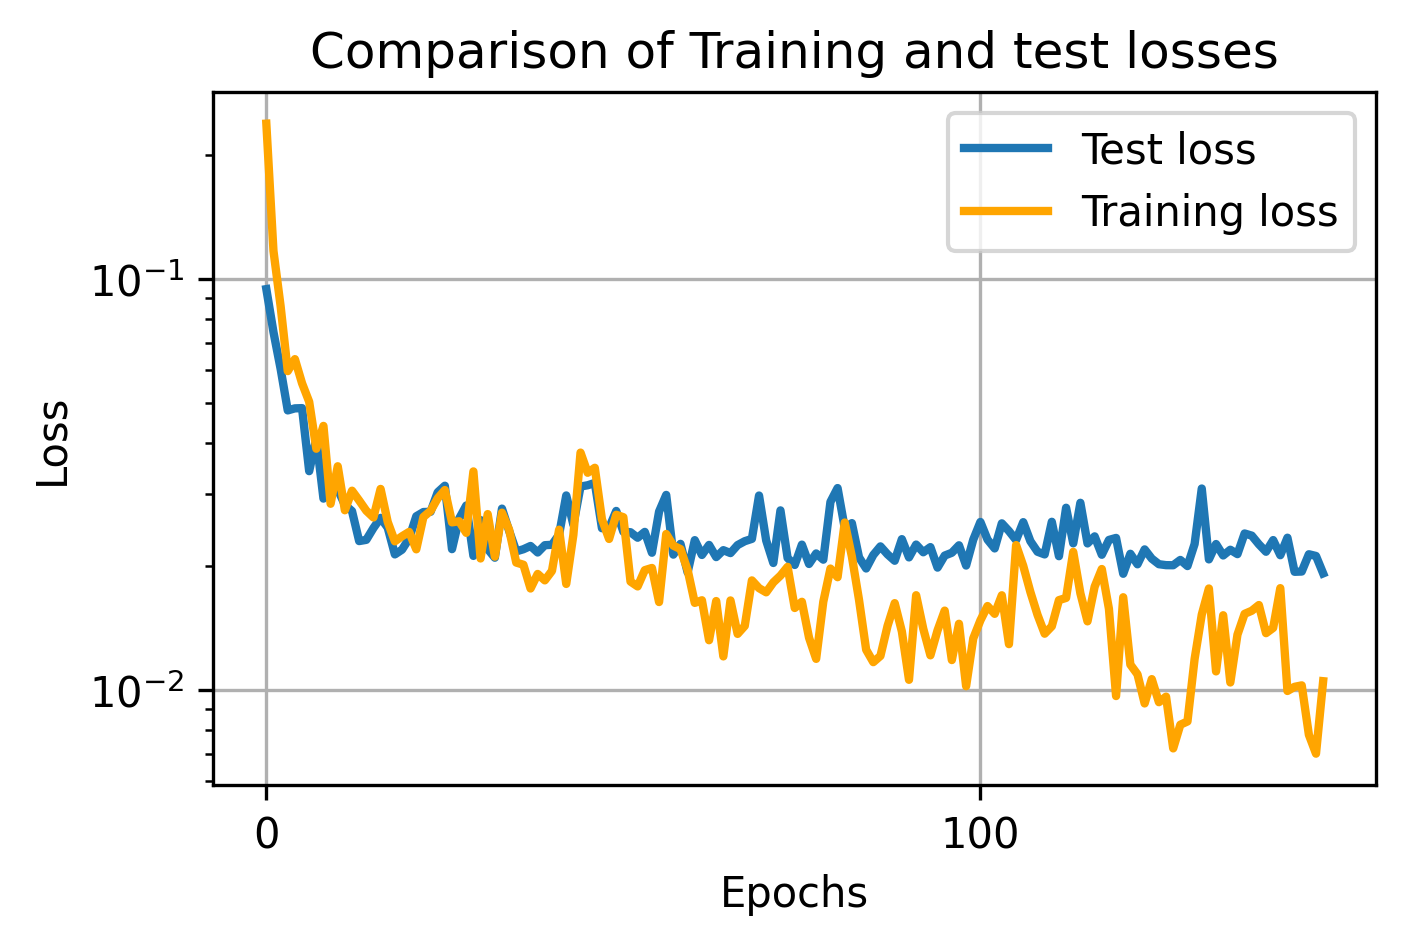

 18%|███████                                 | 177/1000 [07:54<36:30,  2.66s/it]

Epoch 00178: reducing learning rate of group 0 to 3.2768e-04.


 19%|███████▌                                | 188/1000 [08:24<36:01,  2.66s/it]

Epoch 00189: reducing learning rate of group 0 to 2.6214e-04.


 20%|███████▉                                | 198/1000 [08:50<35:32,  2.66s/it]

Epoch:199 
 Training time for  epoch 199: 0.044 minutes,Training loss:  0.006638479884713888, Testing loss: 0.02091462689762314


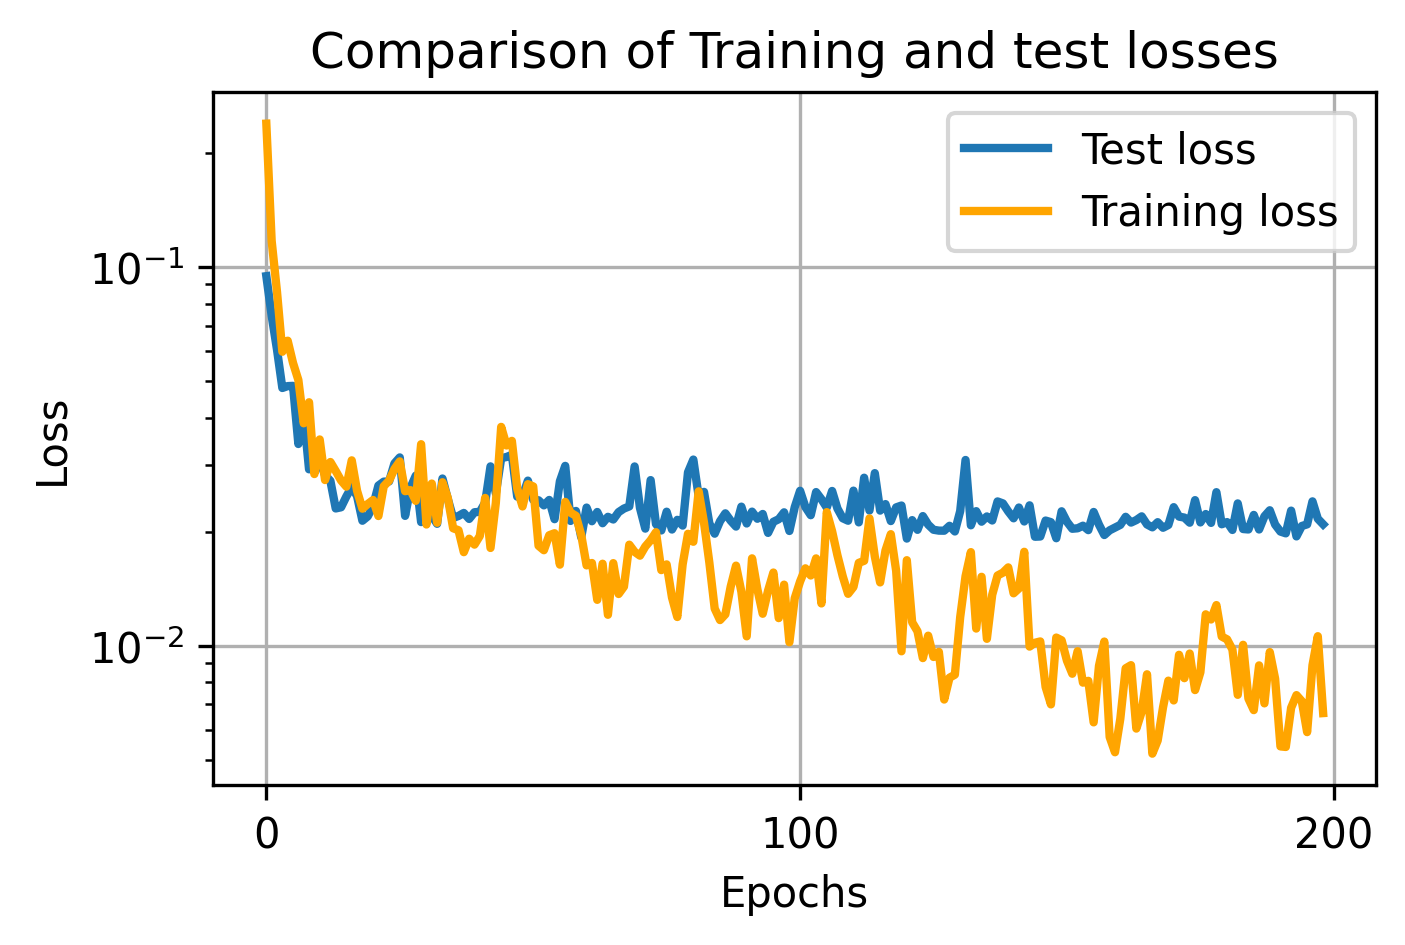

 20%|███████▉                                | 199/1000 [08:53<36:25,  2.73s/it]

Epoch 00200: reducing learning rate of group 0 to 2.0972e-04.


 23%|█████████▎                              | 234/1000 [10:27<34:04,  2.67s/it]

Epoch 00235: reducing learning rate of group 0 to 1.6777e-04.


 24%|█████████▊                              | 245/1000 [10:56<33:30,  2.66s/it]

Epoch 00246: reducing learning rate of group 0 to 1.3422e-04.


 25%|█████████▉                              | 248/1000 [11:04<33:33,  2.68s/it]

Epoch:249 
 Training time for  epoch 249: 0.045 minutes,Training loss:  0.003882581426296383, Testing loss: 0.019784800397853058


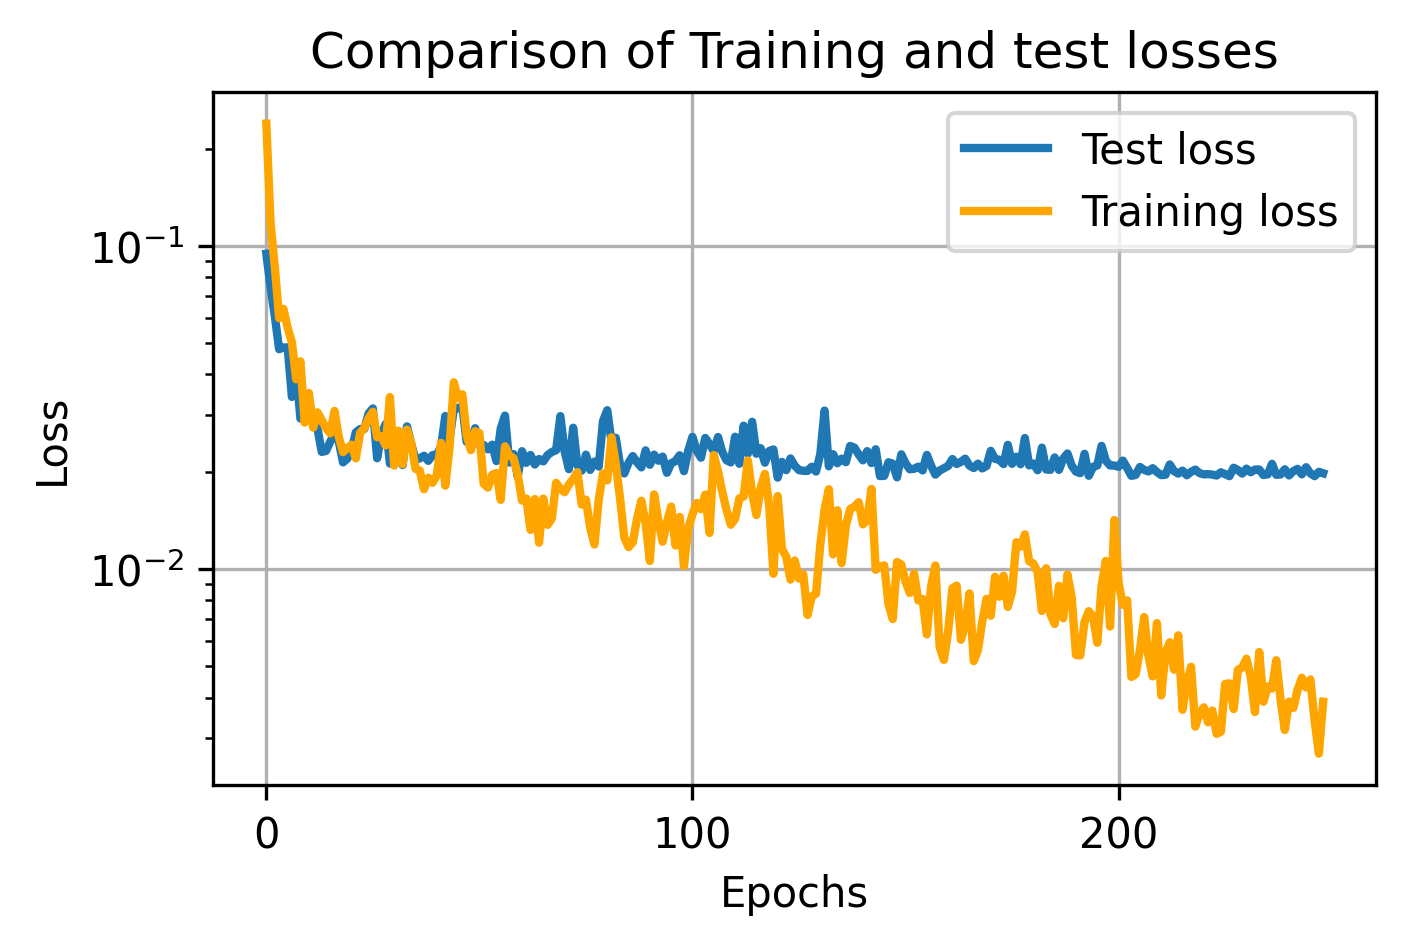

 26%|██████████▎                             | 258/1000 [11:31<32:55,  2.66s/it]

Epoch 00259: reducing learning rate of group 0 to 1.0737e-04.


 28%|███████████                             | 276/1000 [12:19<32:05,  2.66s/it]

Epoch 00277: reducing learning rate of group 0 to 8.5899e-05.


 29%|███████████▍                            | 287/1000 [12:48<31:40,  2.67s/it]

Epoch 00288: reducing learning rate of group 0 to 6.8719e-05.


 30%|███████████▉                            | 298/1000 [13:17<31:13,  2.67s/it]

Epoch:299 
 Training time for  epoch 299: 0.044 minutes,Training loss:  0.0018223145452793688, Testing loss: 0.019340882473625243


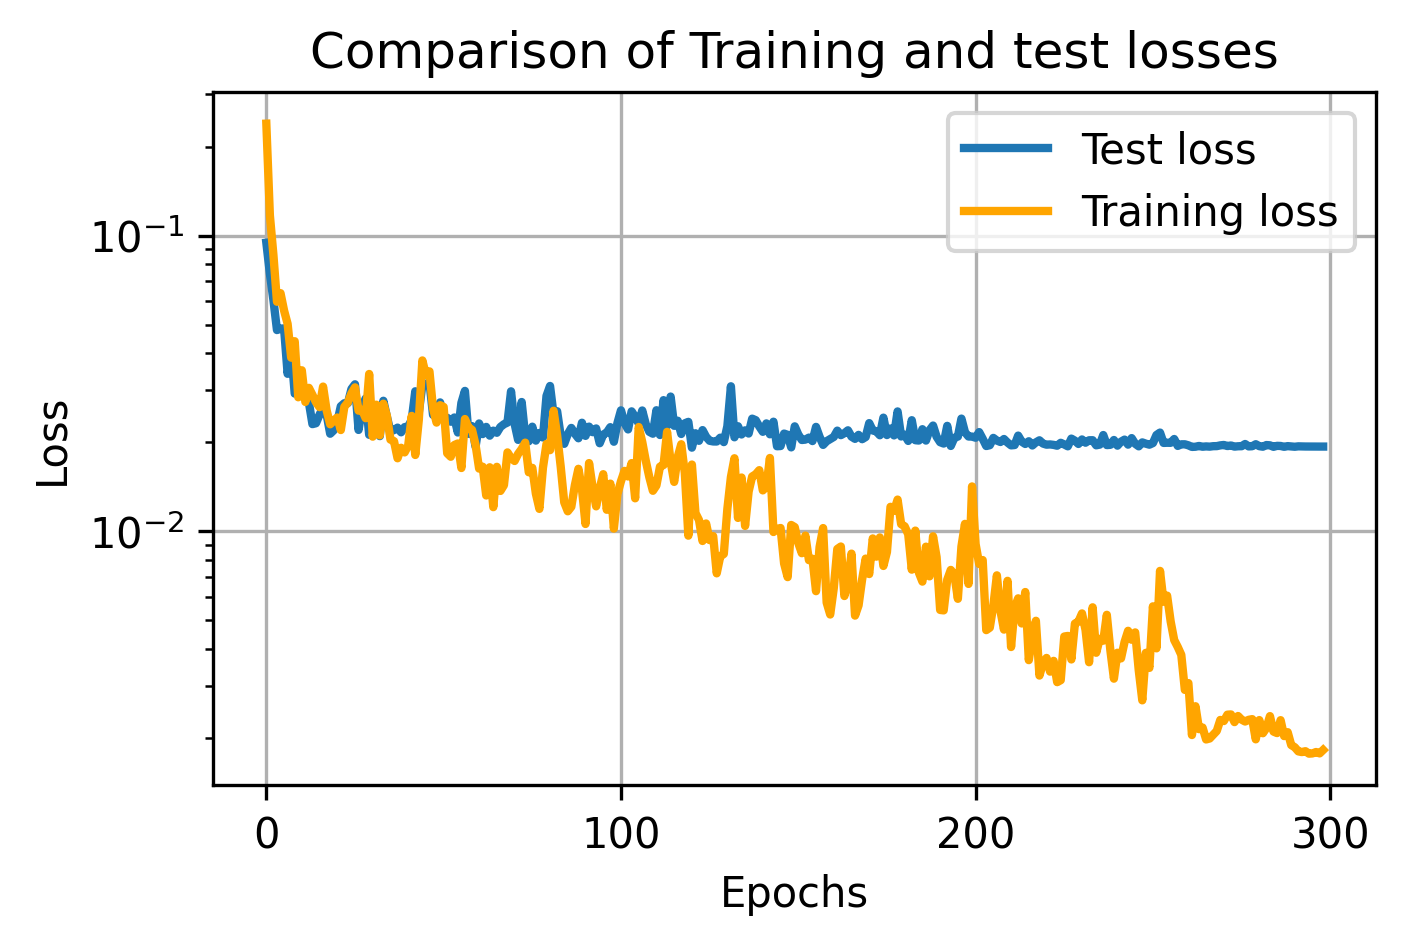

 32%|████████████▉                           | 322/1000 [14:22<29:59,  2.65s/it]

Epoch 00323: reducing learning rate of group 0 to 5.4976e-05.


 33%|█████████████▎                          | 333/1000 [14:51<29:36,  2.66s/it]

Epoch 00334: reducing learning rate of group 0 to 4.3980e-05.


 35%|█████████████▉                          | 348/1000 [15:31<29:02,  2.67s/it]

Epoch:349 
 Training time for  epoch 349: 0.044 minutes,Training loss:  0.0016160976665560156, Testing loss: 0.019317362705866495


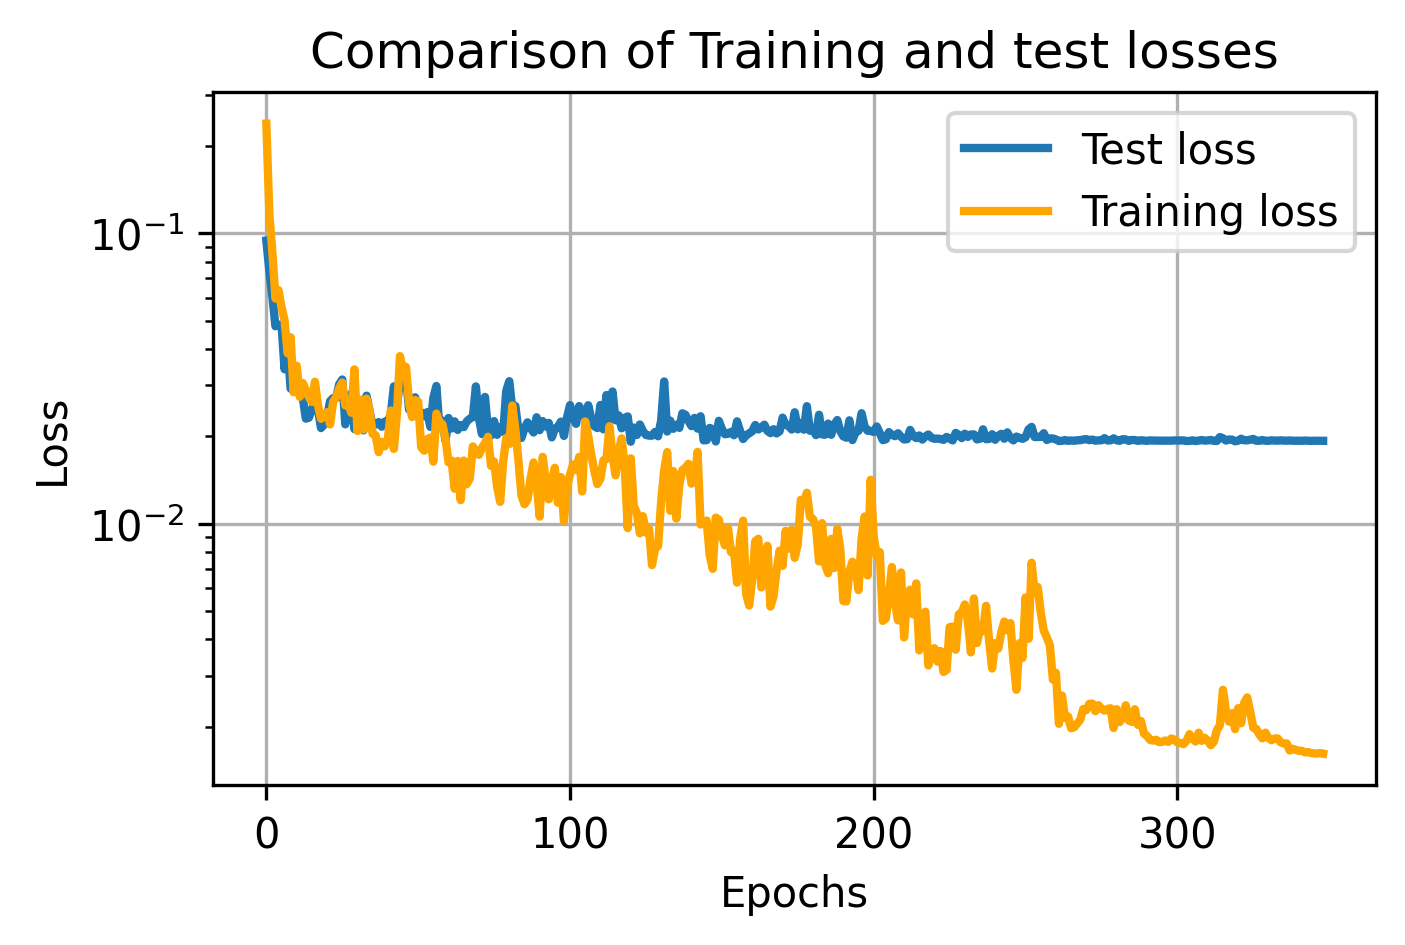

 36%|██████████████▍                         | 361/1000 [16:06<28:15,  2.65s/it]

Epoch 00362: reducing learning rate of group 0 to 3.5184e-05.


 40%|███████████████▉                        | 398/1000 [17:44<26:49,  2.67s/it]

Epoch:399 
 Training time for  epoch 399: 0.045 minutes,Training loss:  0.0015516994753852487, Testing loss: 0.019294094402963917


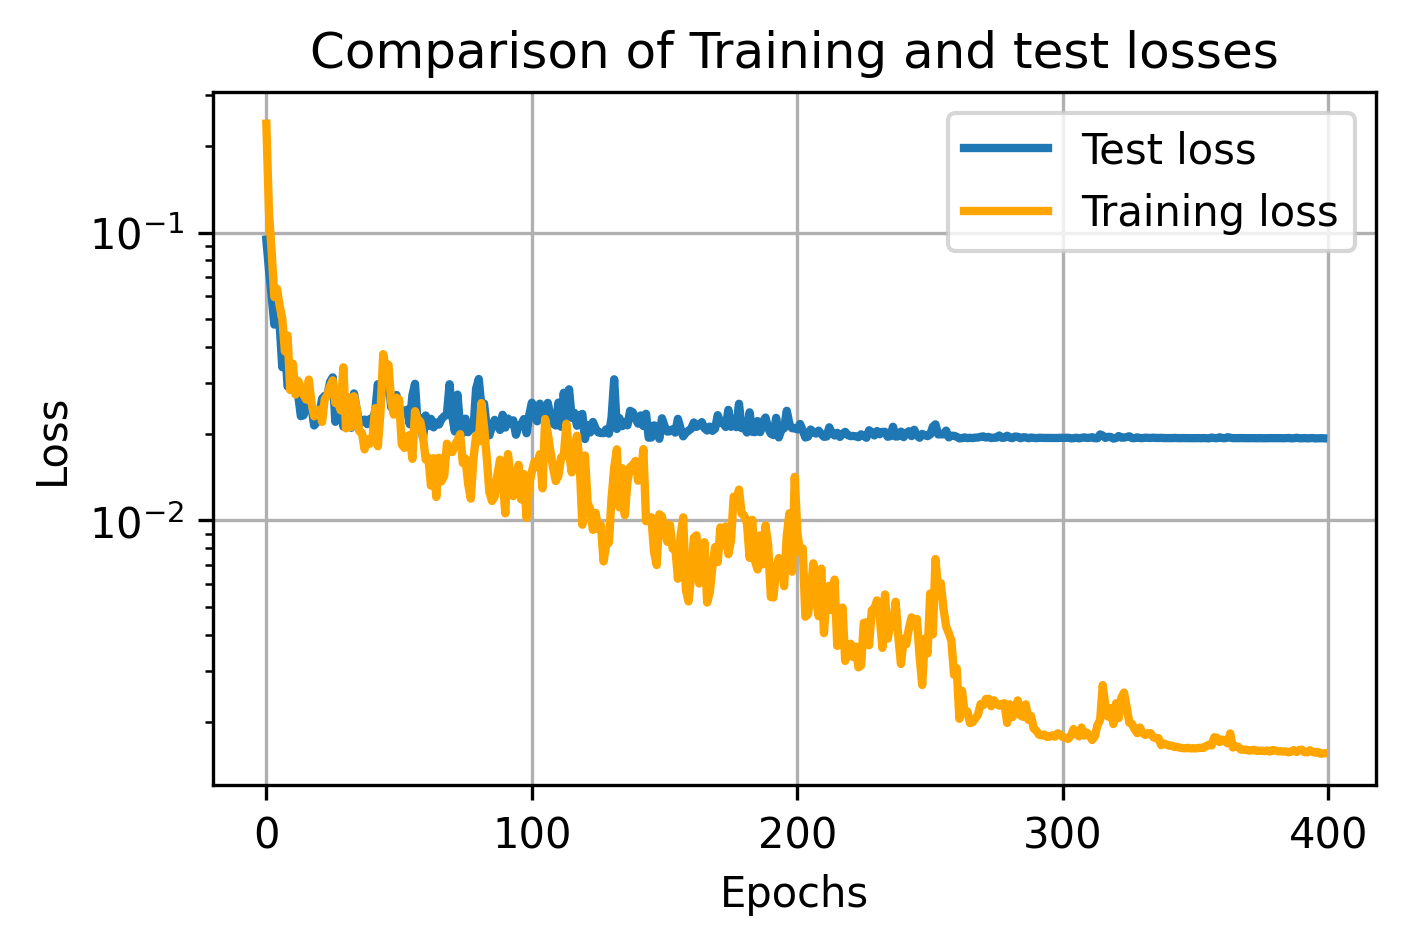

 45%|█████████████████▉                      | 448/1000 [19:58<24:56,  2.71s/it]

Epoch:449 
 Training time for  epoch 449: 0.045 minutes,Training loss:  0.0014855563931632787, Testing loss: 0.019289022024410466


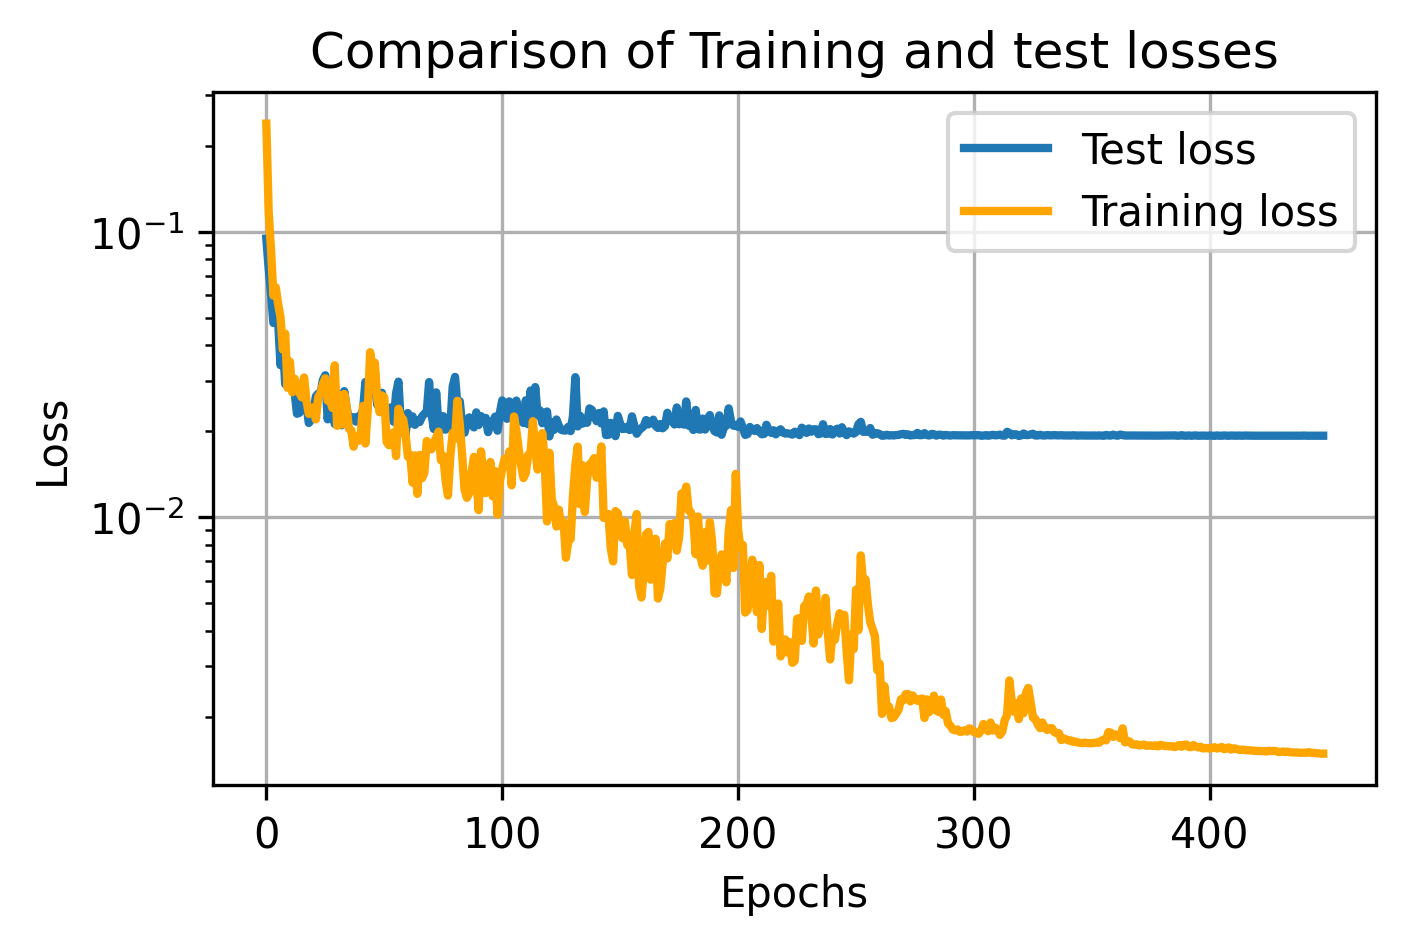

 47%|██████████████████▉                     | 474/1000 [21:08<23:26,  2.67s/it]

Epoch 00475: reducing learning rate of group 0 to 2.8147e-05.


 50%|███████████████████▉                    | 498/1000 [22:12<22:22,  2.67s/it]

Epoch:499 
 Training time for  epoch 499: 0.045 minutes,Training loss:  0.0014347899123094976, Testing loss: 0.01927158737865587


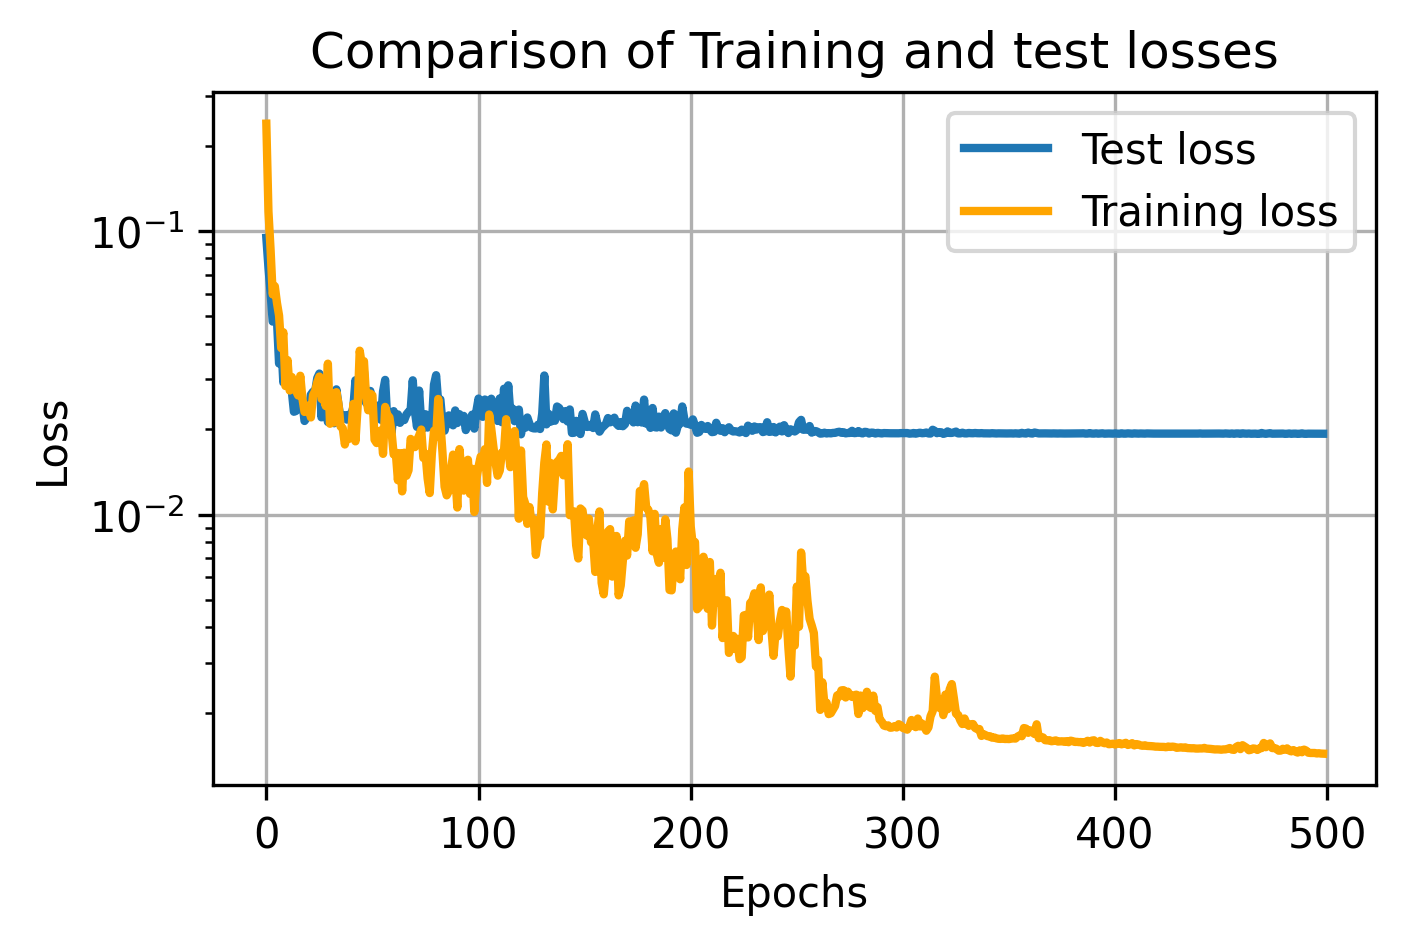

 52%|████████████████████▉                   | 522/1000 [23:16<21:14,  2.67s/it]

Epoch 00523: reducing learning rate of group 0 to 2.2518e-05.


 55%|█████████████████████▉                  | 548/1000 [24:26<20:14,  2.69s/it]

Epoch:549 
 Training time for  epoch 549: 0.045 minutes,Training loss:  0.0013940780772827566, Testing loss: 0.019265917067726453


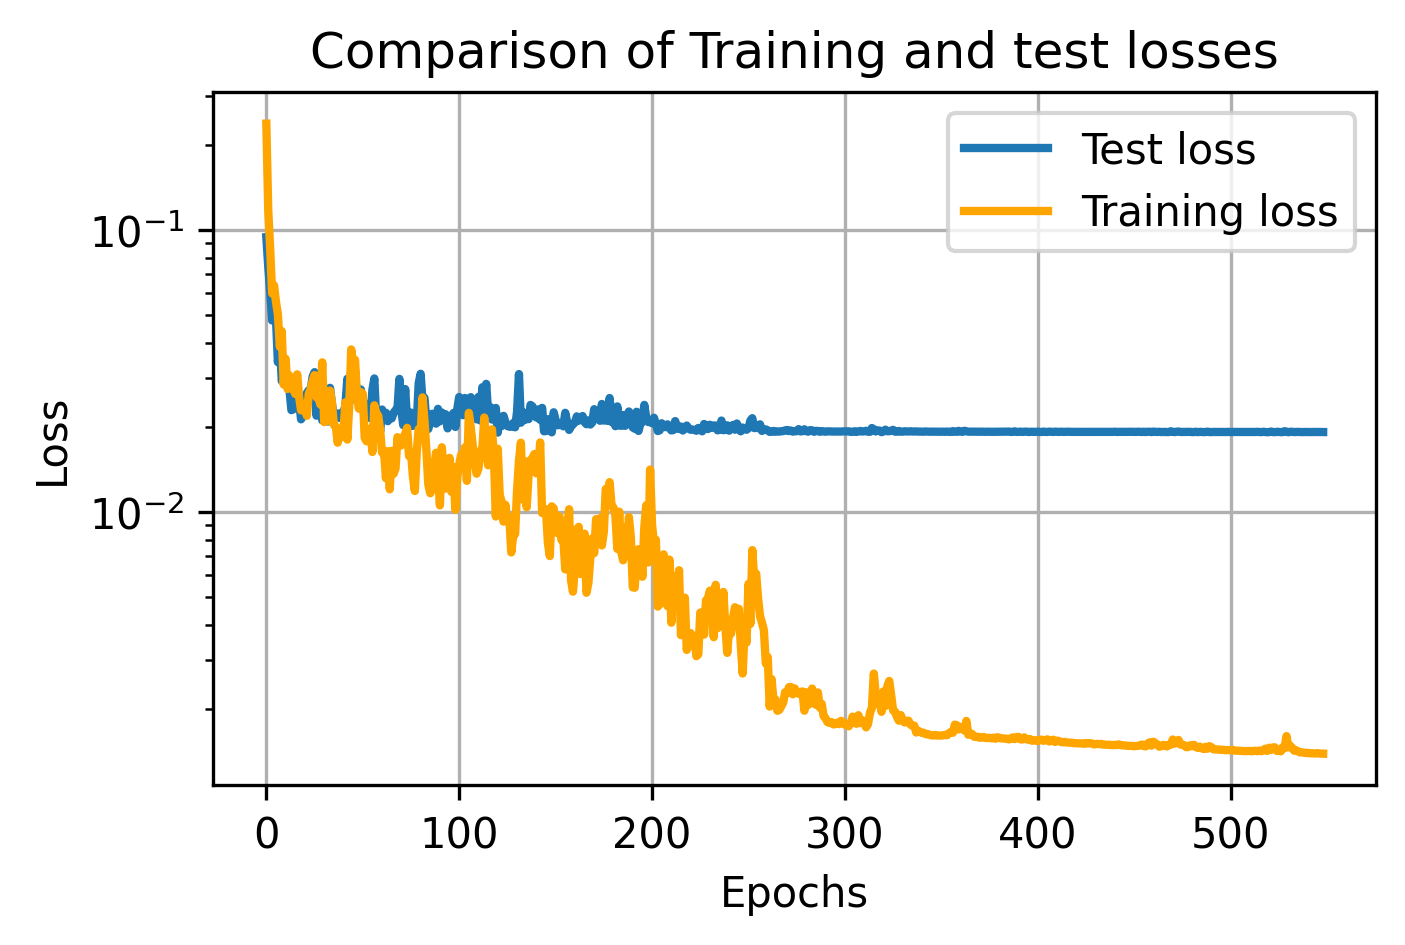

 60%|███████████████████████▉                | 598/1000 [26:40<17:57,  2.68s/it]

Epoch:599 
 Training time for  epoch 599: 0.044 minutes,Training loss:  0.001372272236039862, Testing loss: 0.01926241038988034


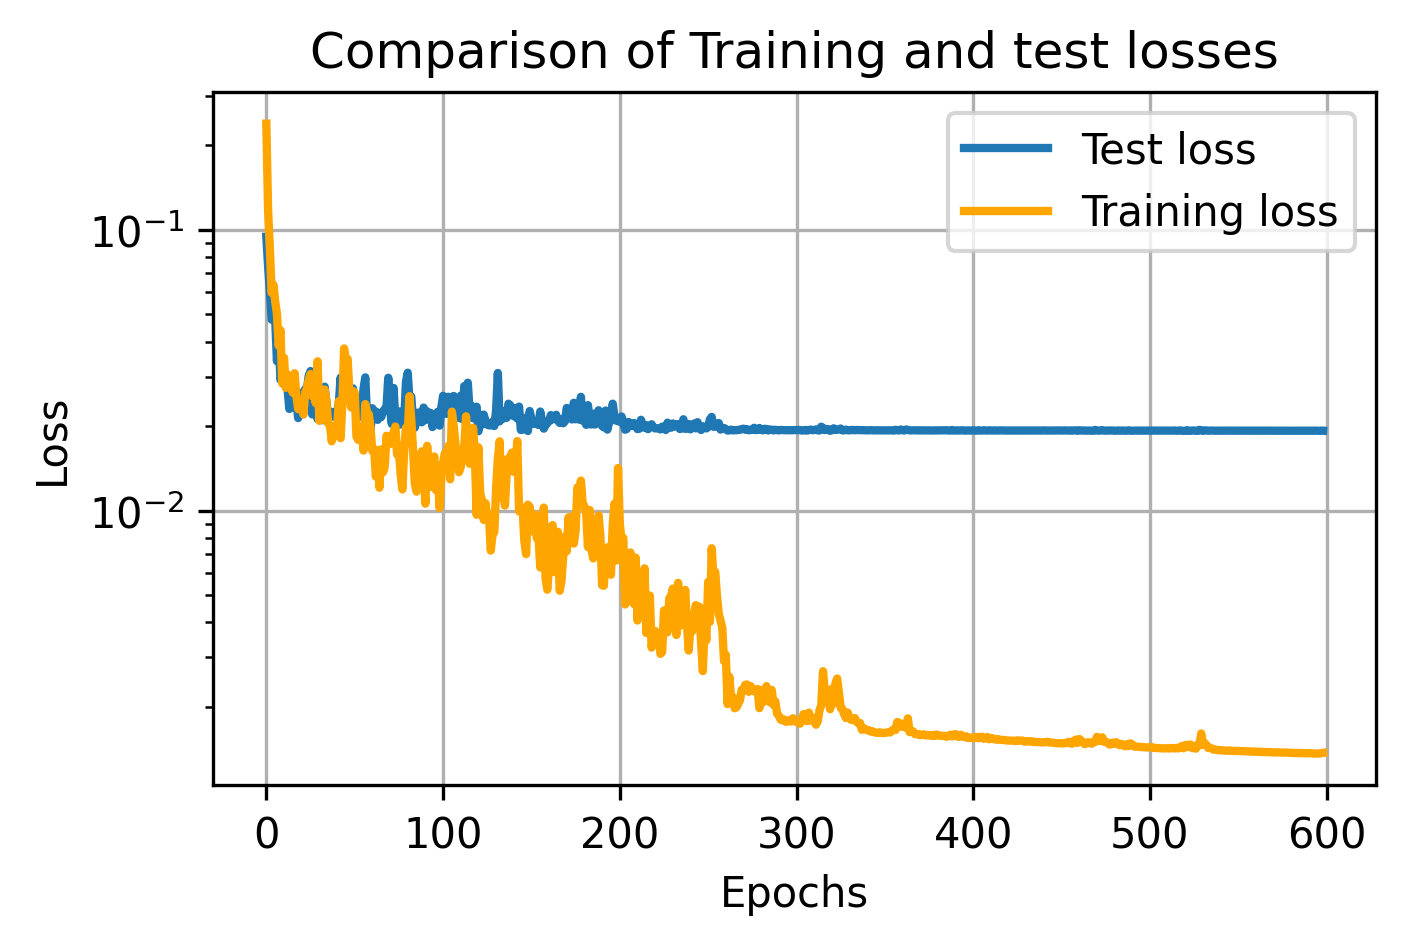

 61%|████████████████████████▍               | 610/1000 [27:13<17:36,  2.71s/it]

Epoch 00611: reducing learning rate of group 0 to 1.8014e-05.


 65%|█████████████████████████▉              | 648/1000 [28:55<15:46,  2.69s/it]

Epoch:649 
 Training time for  epoch 649: 0.045 minutes,Training loss:  0.0013311783550307155, Testing loss: 0.019258887064643203


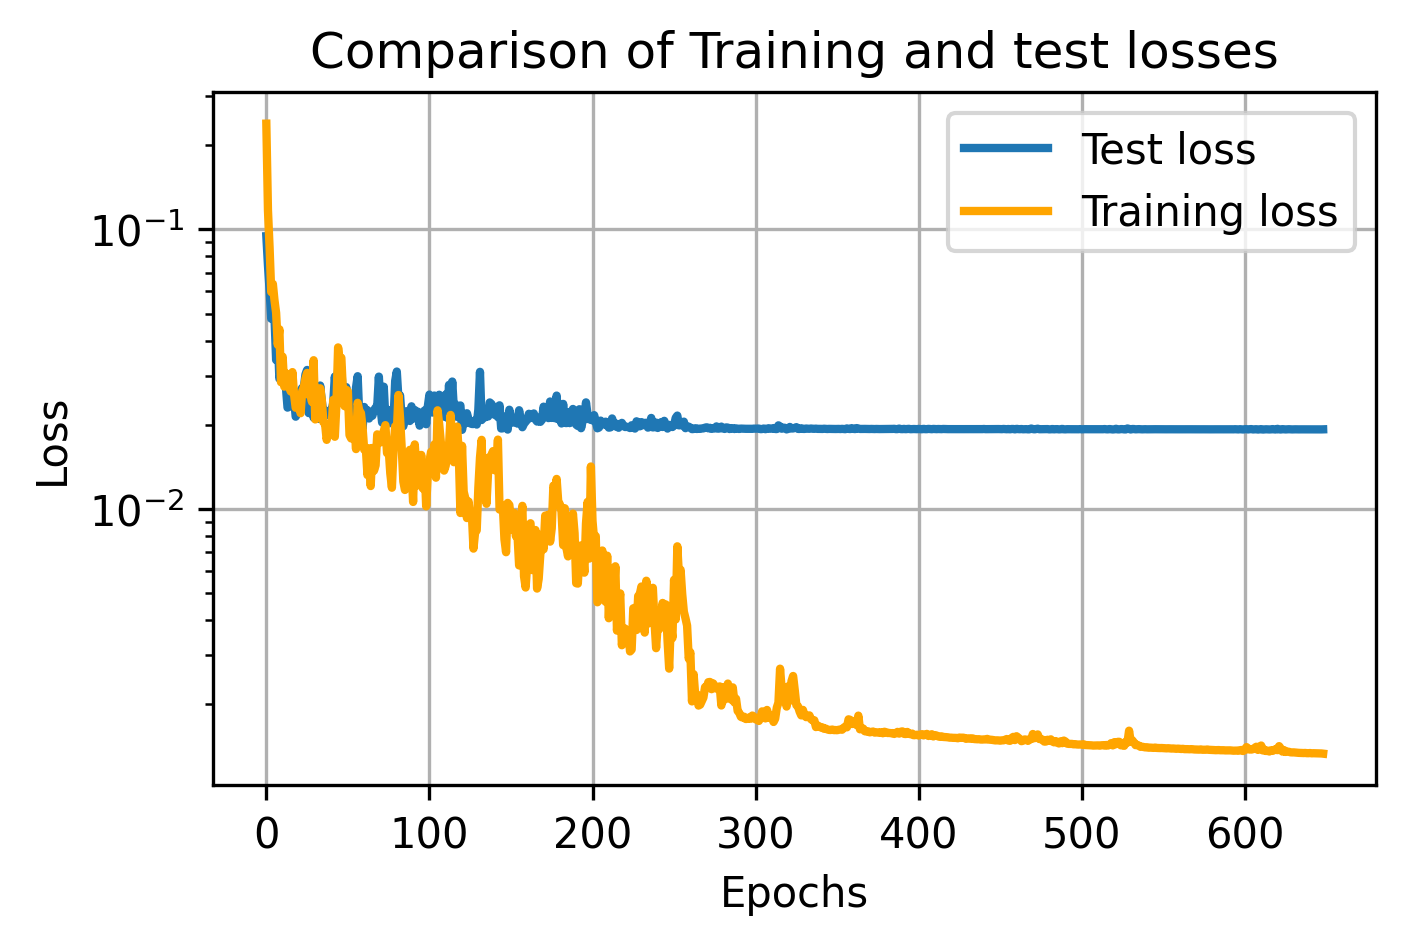

 70%|███████████████████████████▉            | 698/1000 [31:09<13:26,  2.67s/it]

Epoch:699 
 Training time for  epoch 699: 0.045 minutes,Training loss:  0.0013083051599096507, Testing loss: 0.01925165979191661


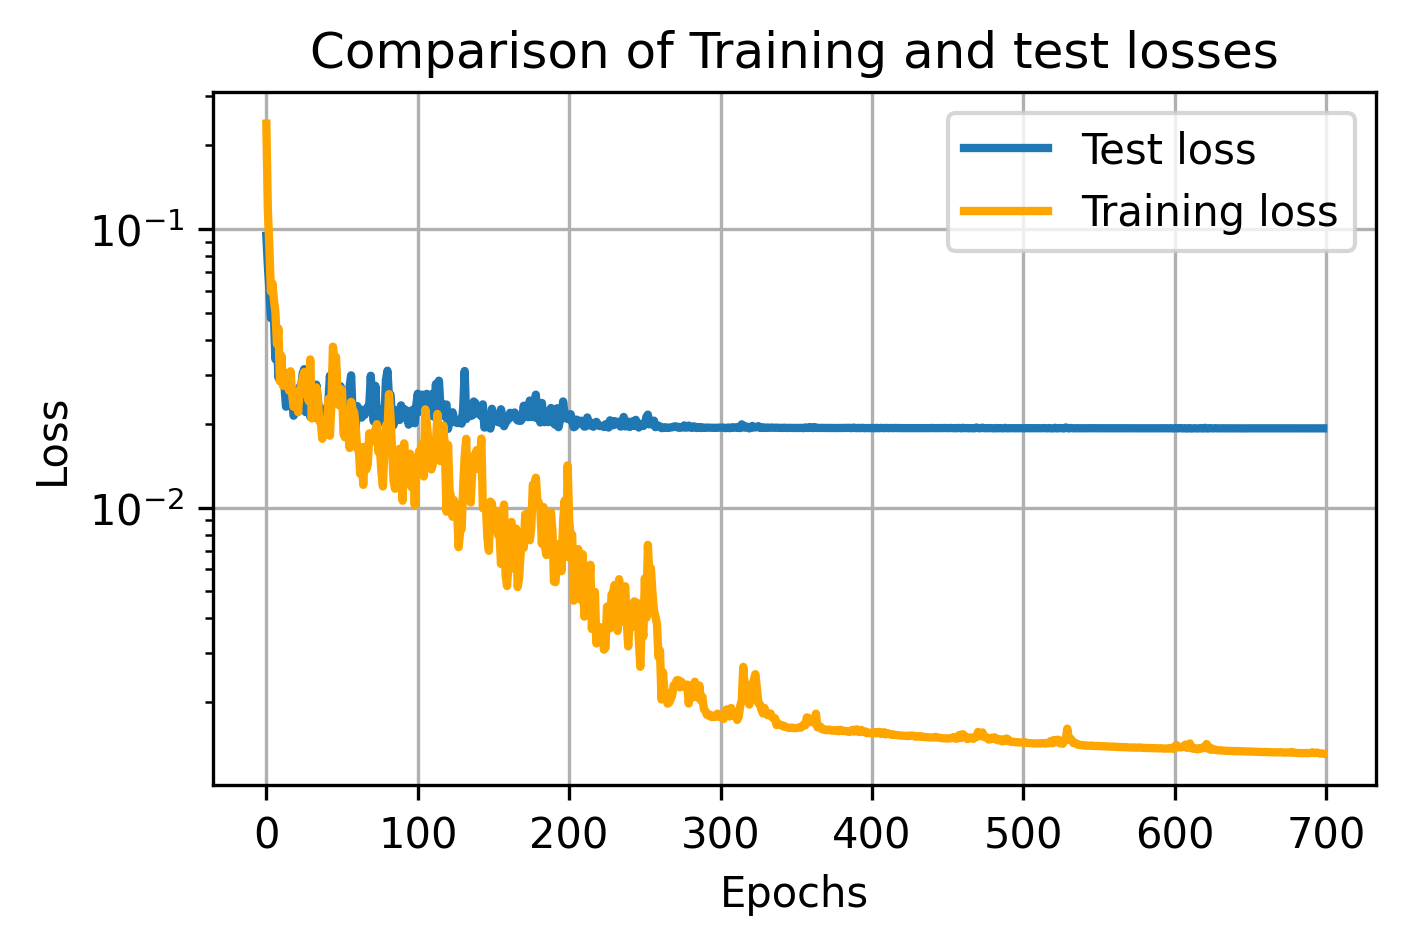

 72%|████████████████████████████▋           | 717/1000 [32:00<12:32,  2.66s/it]

Epoch 00718: reducing learning rate of group 0 to 1.4412e-05.


 73%|█████████████████████████████           | 728/1000 [32:29<12:04,  2.66s/it]

Epoch 00729: reducing learning rate of group 0 to 1.1529e-05.


 75%|█████████████████████████████▉          | 748/1000 [33:23<11:13,  2.67s/it]

Epoch:749 
 Training time for  epoch 749: 0.045 minutes,Training loss:  0.0012849826889578253, Testing loss: 0.019234819174744188


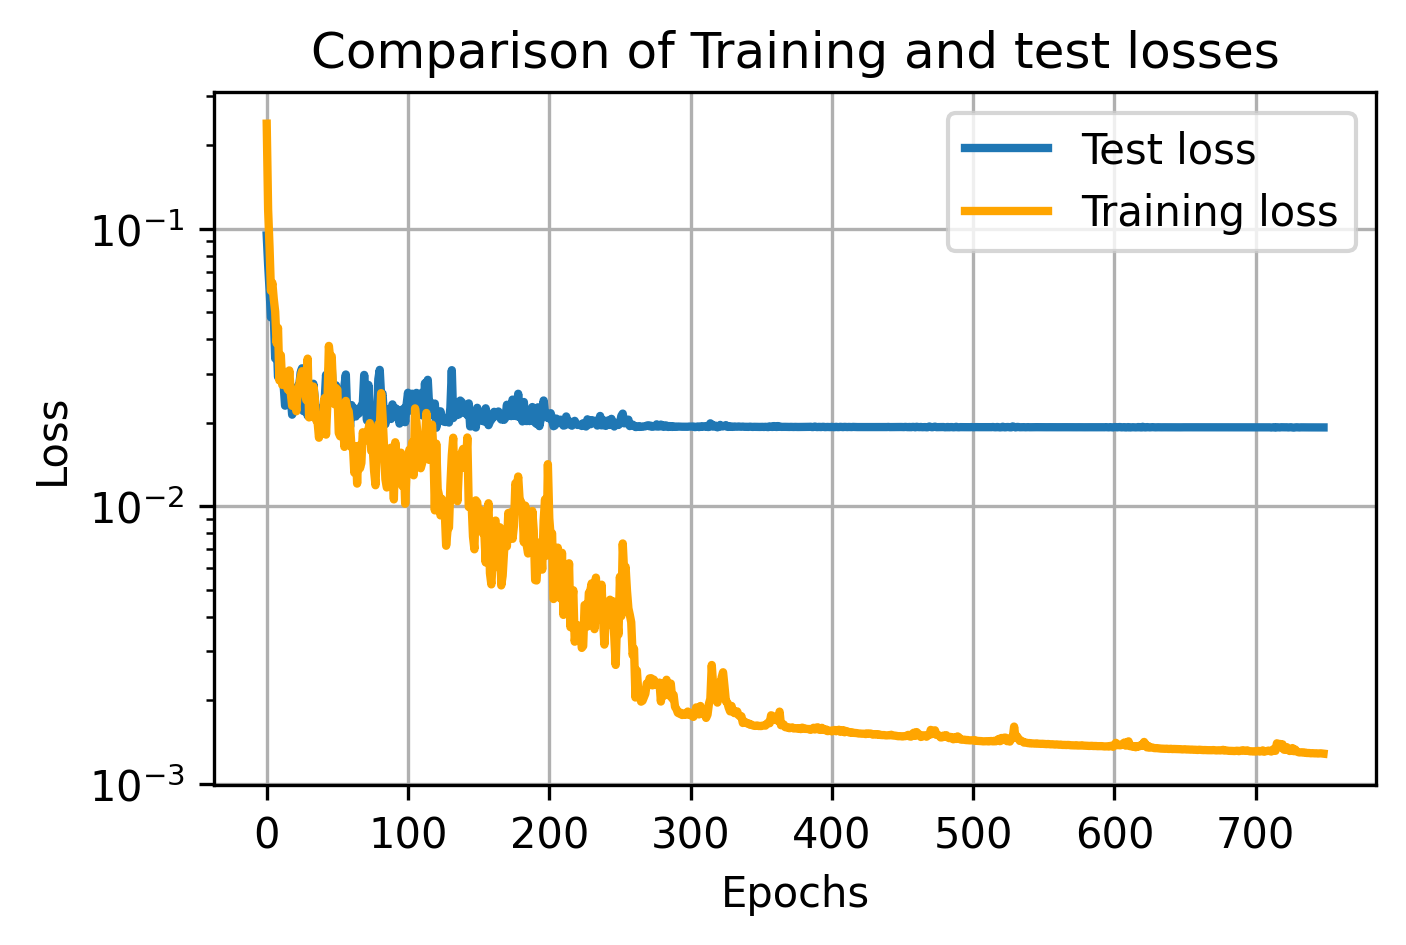

 80%|███████████████████████████████▉        | 798/1000 [35:36<08:58,  2.66s/it]

Epoch:799 
 Training time for  epoch 799: 0.044 minutes,Training loss:  0.00126881169853732, Testing loss: 0.01923878613548974


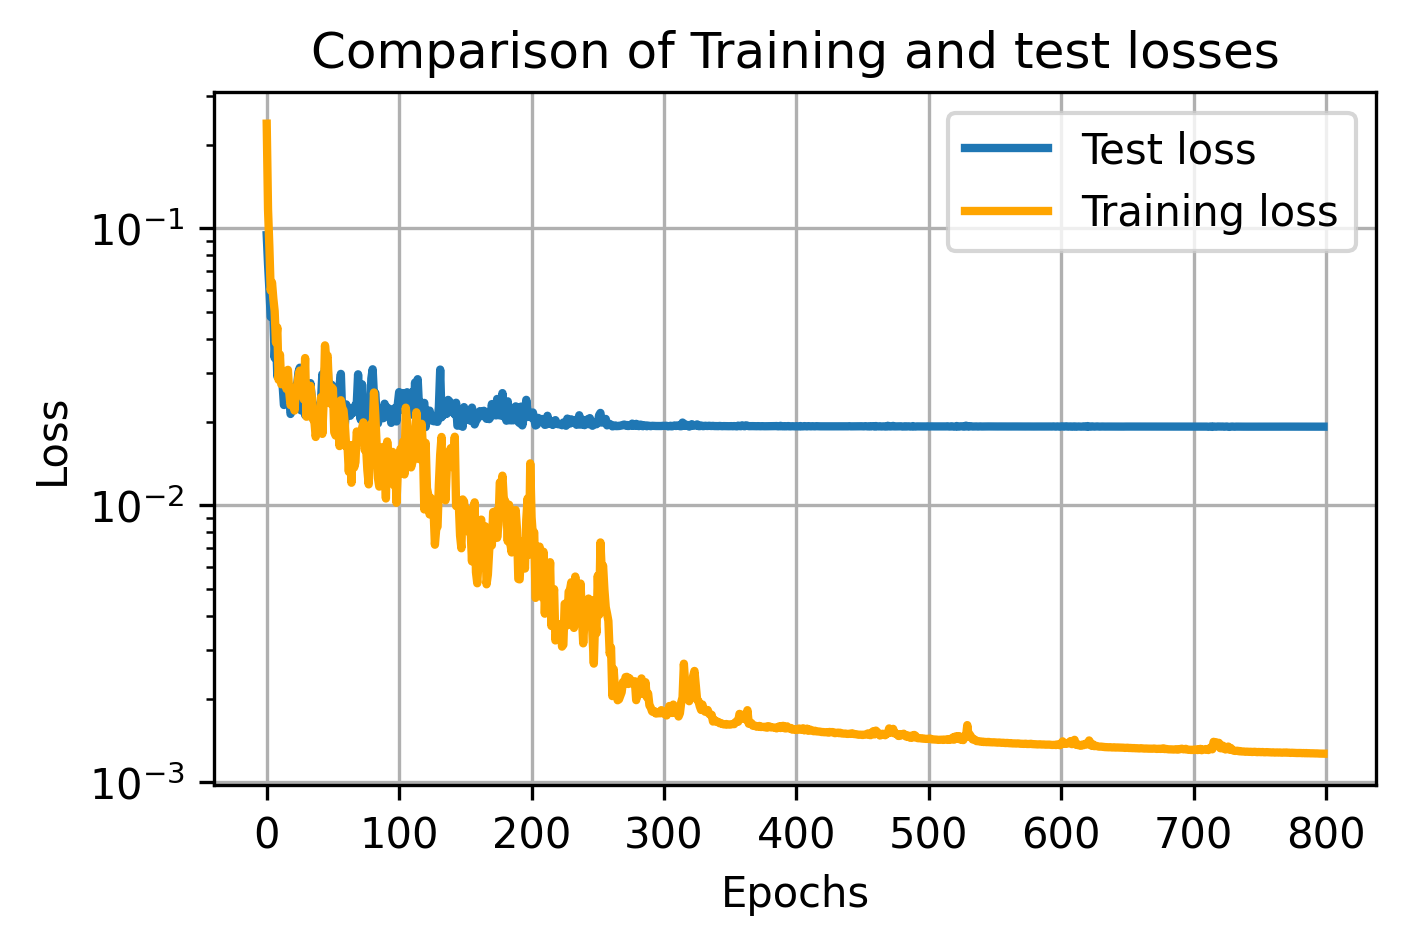

 85%|█████████████████████████████████▉      | 848/1000 [37:49<06:44,  2.66s/it]

Epoch:849 
 Training time for  epoch 849: 0.044 minutes,Training loss:  0.0012549766979645938, Testing loss: 0.019233134846823912


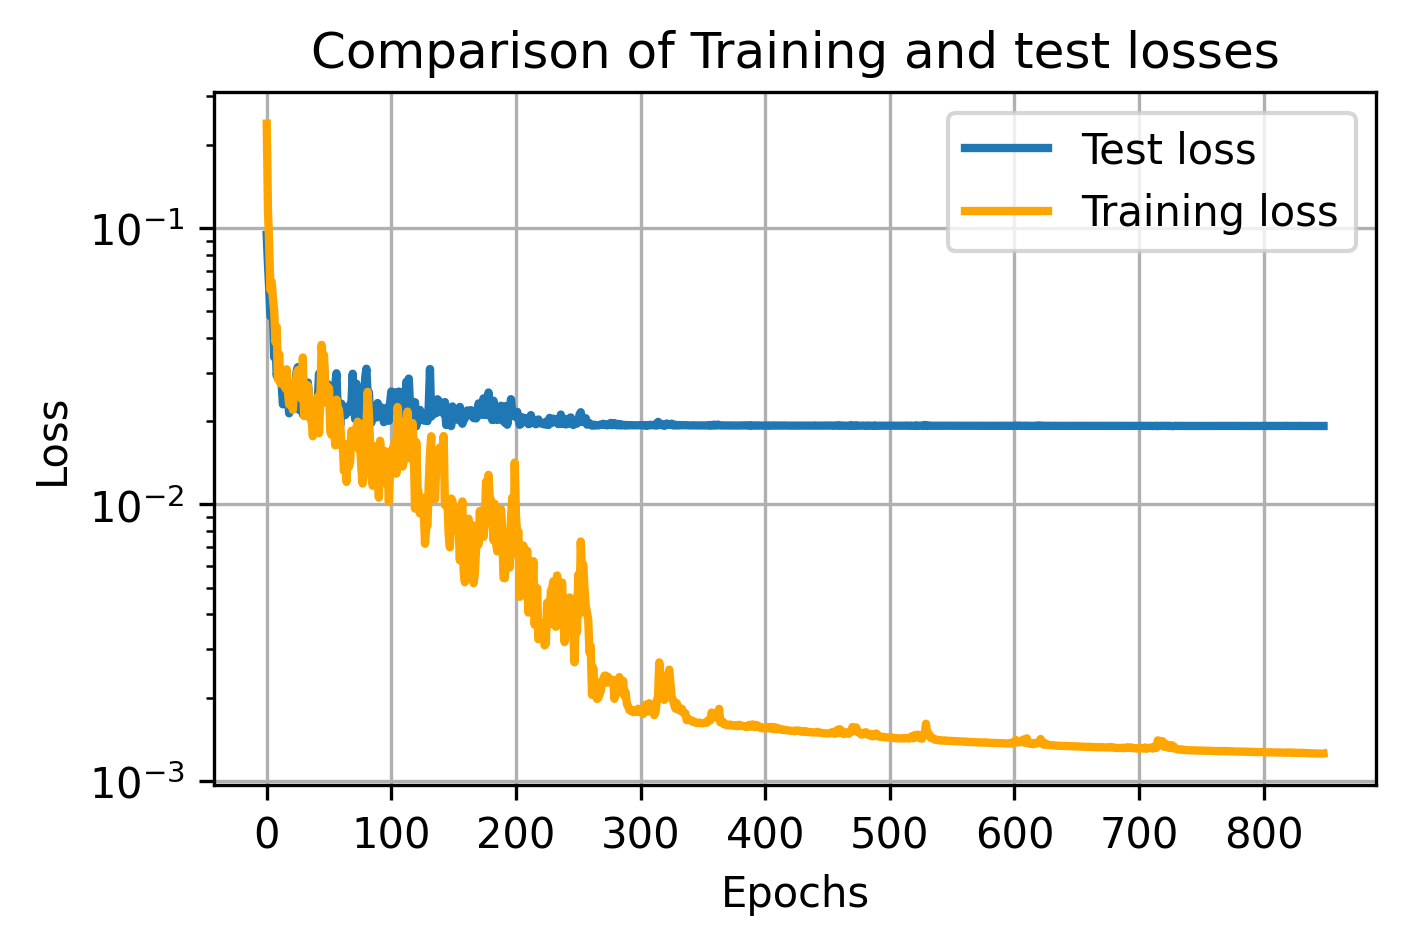

 90%|███████████████████████████████████▉    | 898/1000 [40:03<04:31,  2.66s/it]

Epoch:899 
 Training time for  epoch 899: 0.044 minutes,Training loss:  0.0012383028952172026, Testing loss: 0.019224146470272294


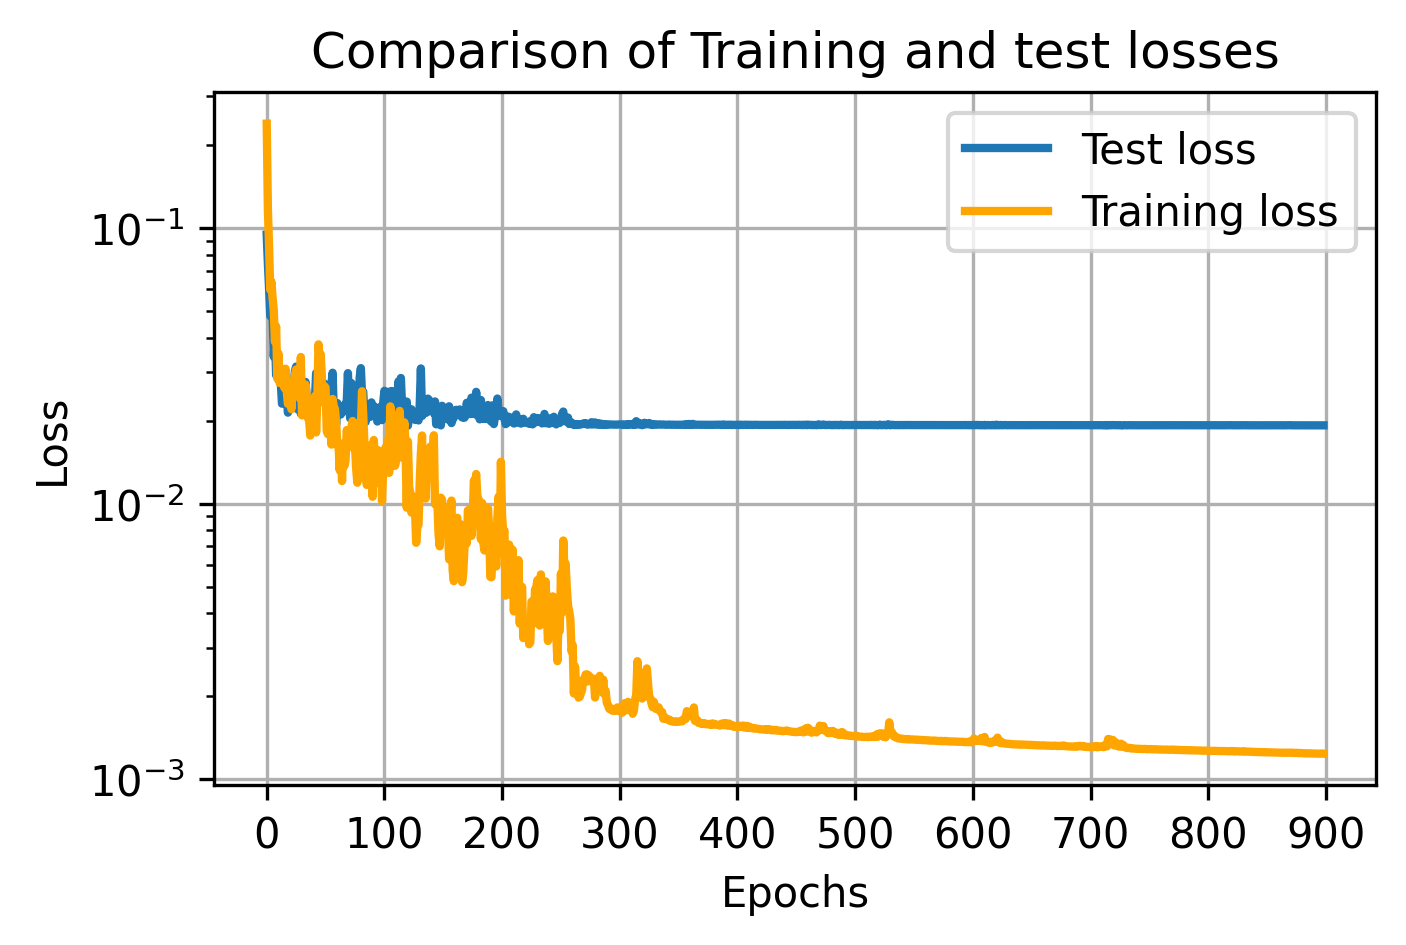

 93%|█████████████████████████████████████▏  | 930/1000 [41:28<03:05,  2.65s/it]

Epoch 00931: reducing learning rate of group 0 to 9.2234e-06.


 95%|█████████████████████████████████████▉  | 948/1000 [42:16<02:18,  2.65s/it]

Epoch:949 
 Training time for  epoch 949: 0.044 minutes,Training loss:  0.0012568534875754267, Testing loss: 0.019202138592178623


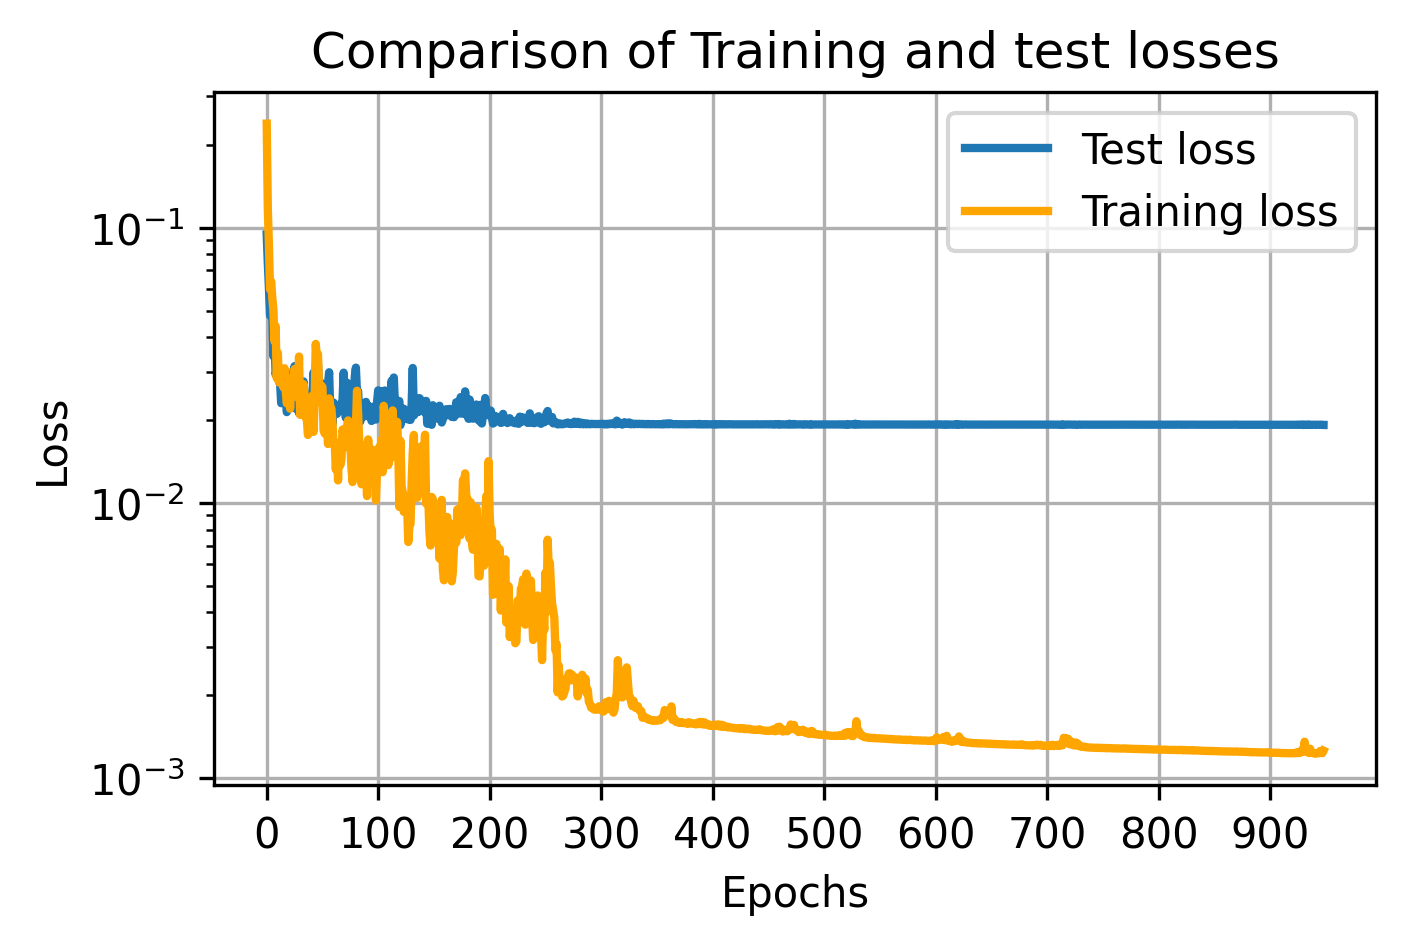

 95%|██████████████████████████████████████  | 952/1000 [42:27<02:08,  2.68s/it]

Epoch 00953: reducing learning rate of group 0 to 7.3787e-06.


100%|███████████████████████████████████████▉| 998/1000 [44:29<00:05,  2.66s/it]

Epoch:999 
 Training time for  epoch 999: 0.044 minutes,Training loss:  0.0012106776412110776, Testing loss: 0.019226494544030477


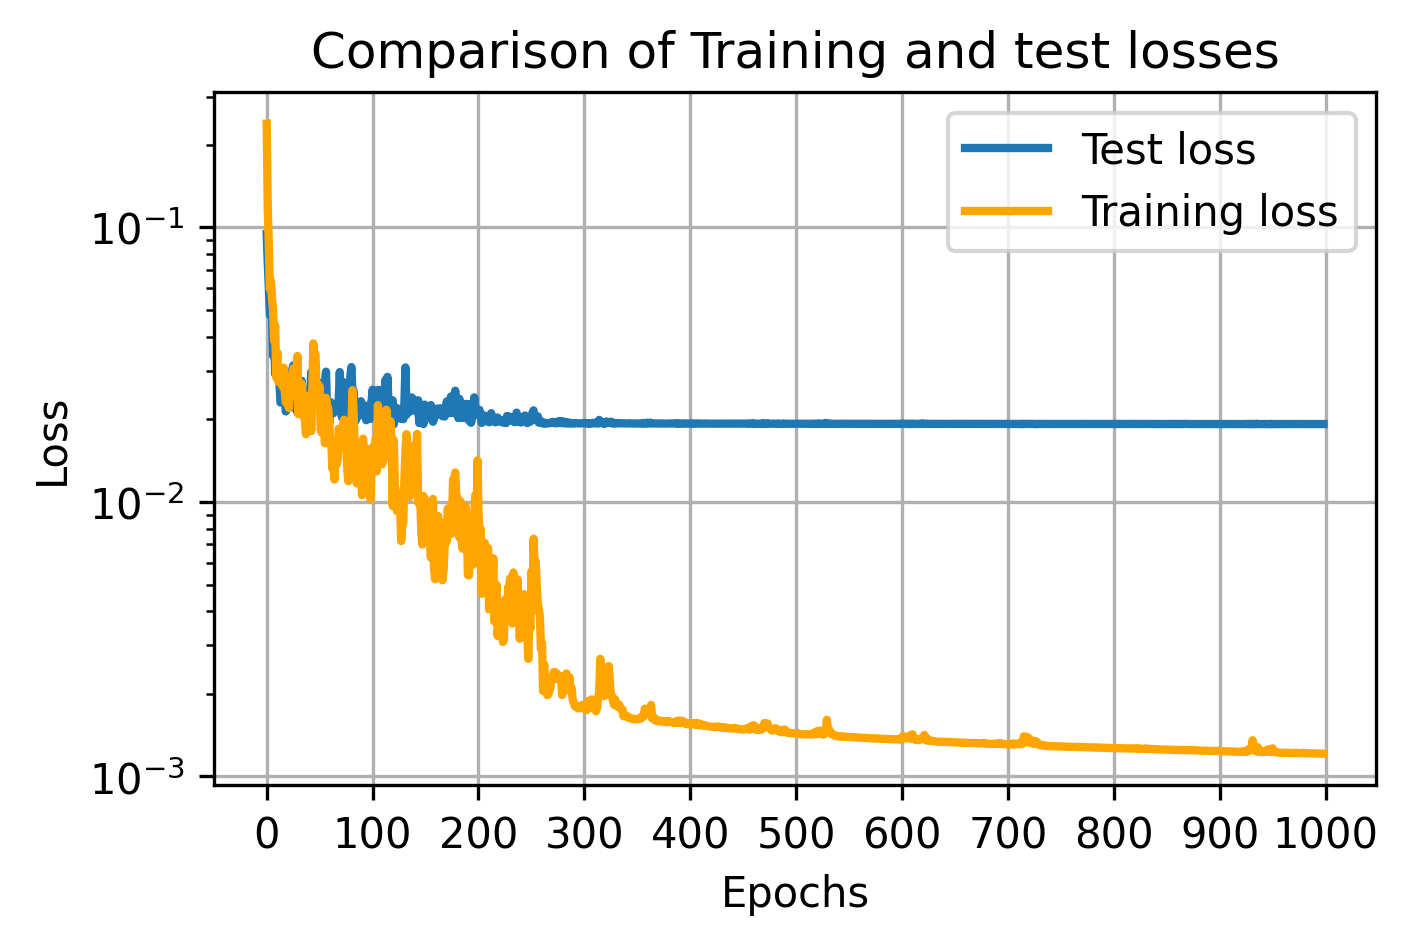

100%|███████████████████████████████████████| 1000/1000 [44:35<00:00,  2.68s/it]

Total training time 44.589 minutes


In [77]:
# Model training

start_training = default_timer()

epochs = 1000

train_loss = torch.zeros(epochs)
test_loss = torch.zeros(epochs)
best_val_loss = float('inf')
trigger_times = 0  # Counter for early stopping

for ep in tqdm(range(1,epochs+1)):
    
    model.train()
    t1 = default_timer()
    train_l2 = 0
    
    for x, y in train_loader:
        
        x, y = x.cuda(), y.cuda()

        optimizer.zero_grad()
        out = model(x).reshape(batch_size, nz, nx)

        loss = myloss(out.view(batch_size,-1), y.view(batch_size,-1)) 
        loss.backward()
        
        optimizer.step()        
        train_l2 += loss.item()

    train_l2 /= len(x_train)
    train_loss[ep-1] = train_l2
    
    scheduler.step( train_l2 ) # Update learning rate with average of train events

    # Early stopping logic
    if train_l2 < best_val_loss:
        
        best_val_loss = train_l2
        trigger_times = 0  # Reset the counter if validation loss improves
        
        # Optionally, save the model with the best validation loss
        torch.save( model.state_dict(), model_name )
        
    else:
        
        trigger_times += 1
        
        if trigger_times >= patience:
            
            print(f"Early stopping at epoch {ep}")
            break  # Stop training if validation loss hasn't improved in 'patience' epochs


    
    model.eval()    
    test_l2 = 0.0
      
    with torch.no_grad():
        
        for x, y in test_loader:
            
            x, y = x.cuda(), y.cuda()

            out = model(x).reshape( batch_size, nz, nx )

            test_l2 += myloss(out.view(batch_size,-1), y.view(batch_size,-1)).item()
        
    test_l2 /= len(x_test)    
    test_loss[ep-1] = test_l2
    
    t2 = default_timer()
    
    if (ep+1) % 50 == 0:

        print(f'Epoch:{ep} \n Training time for  epoch {ep}: {round((t2-t1)/60,3)} minutes,Training loss:  {train_l2}, Testing loss: {test_l2}')

        # Loss Figure
        fig = plt.figure(figsize=(5, 3), dpi=300)
        ax = plt.axes()
            
        ax.semilogy( test_loss[:ep], linewidth=2, label = 'Test loss')
        ax.semilogy( train_loss[:ep], linewidth=2, label = 'Training loss', color = 'orange')
        ax.set_xlabel('Epochs', fontsize=10)
        plt.xticks(fontsize=10)
        ax.xaxis.set_major_locator(plt.MultipleLocator(100))        
        ax.set_ylabel('Loss', fontsize=10)
        plt.yticks(fontsize=10)
        plt.grid()
        plt.legend(loc='upper right')
        plt.title('Comparison of Training and test losses')
        plt.show()

end = default_timer() - start_training

if end > 3600:
    print(f'Total training time {round(end/3600,3)} hours')
else:
    print(f'Total training time {round(end/60,3)} minutes')

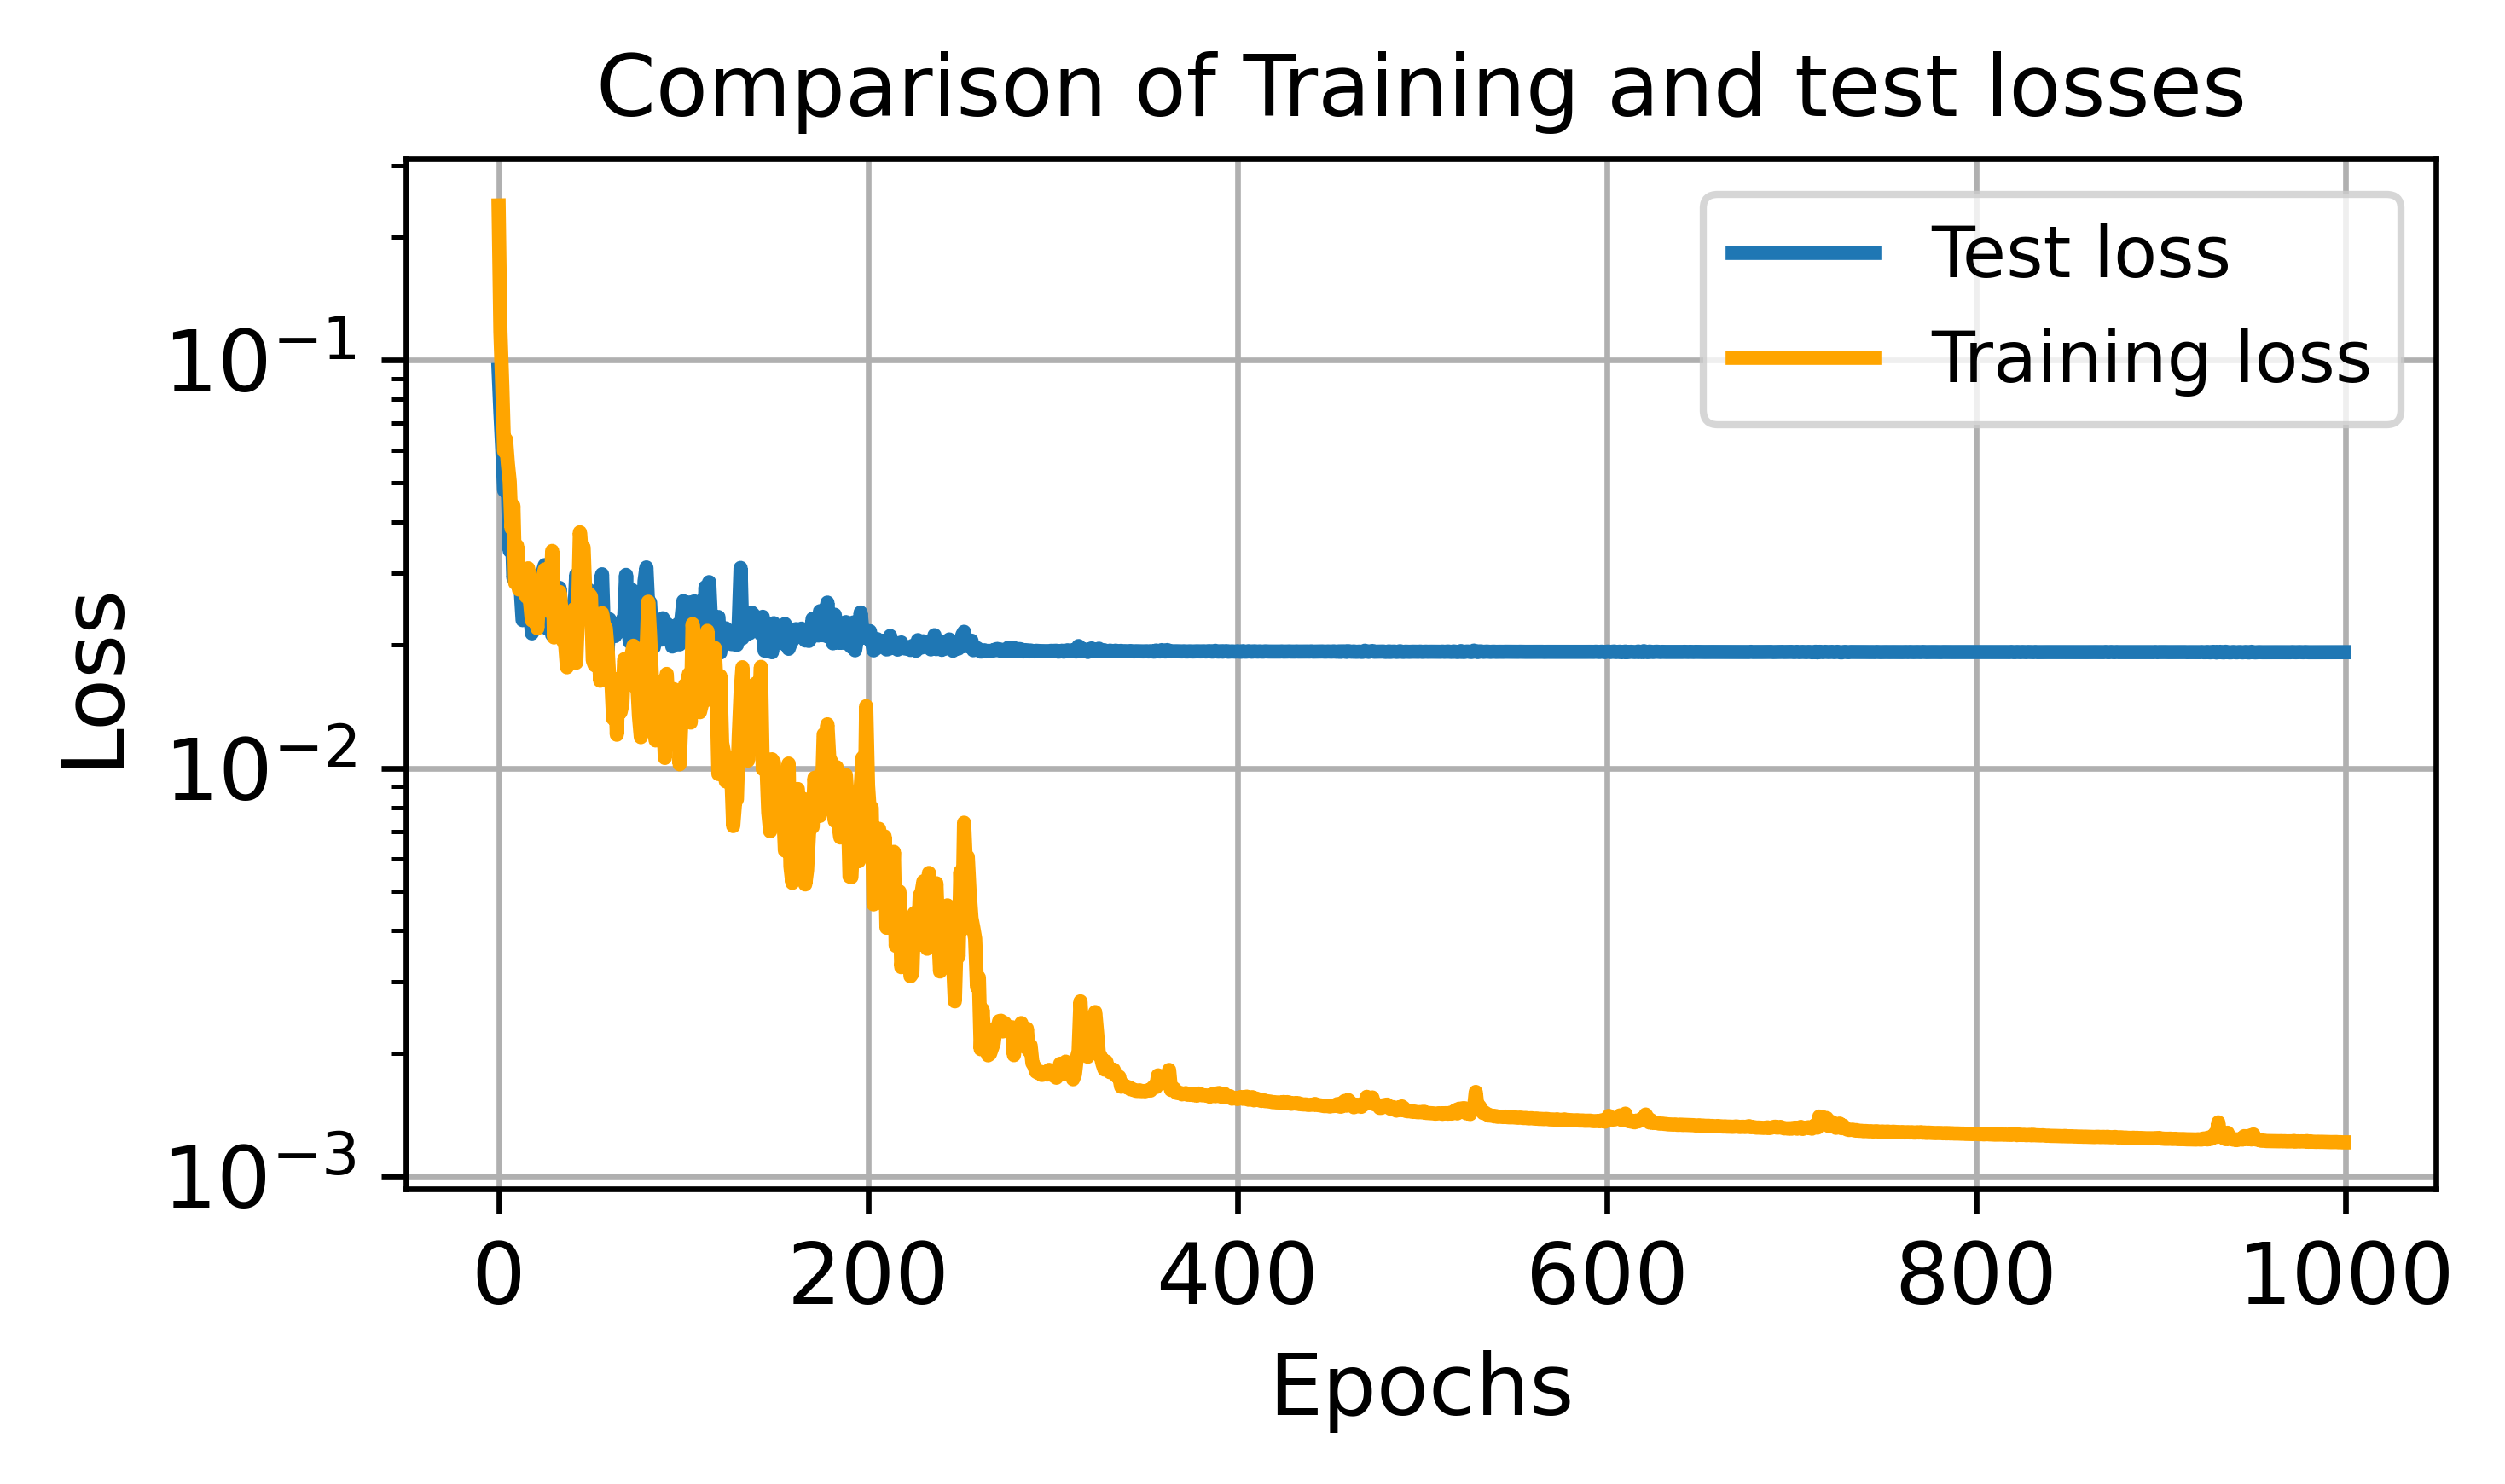

In [78]:
# Convergence history plot for verification

plt.style.use('default')
fig = plt.figure(figsize=(5, 3), dpi=600)
ax = plt.axes()

ax.semilogy(test_loss[:ep], linewidth=2, label = 'Test loss')
ax.semilogy(train_loss[:ep], linewidth=2, label = 'Training loss', color = 'orange')

ax.set_xlabel('Epochs', fontsize=12)
plt.xticks(fontsize=12)
ax.xaxis.set_major_locator(plt.MultipleLocator(200))

ax.set_ylabel('Loss', fontsize=12)
plt.yticks(fontsize=12)

plt.grid()
plt.legend(loc='upper right')
plt.title('Comparison of Training and test losses')

plt.tight_layout()

# plt.savefig( 'Loss_forgeTL_'+str(int(spacing))+'m_m12w24.png' , dpi=600 )

plt.show()

In [79]:
# To load the model if available

# model_name = 'Model_forgeTL_25m_m12w24_best.pt'

# model.load_state_dict(torch.load(model_name))

model.eval()

FNO2d(
  (fc0): Linear(in_features=3, out_features=24, bias=True)
  (conv0): SpectralConv2d()
  (conv1): SpectralConv2d()
  (conv2): SpectralConv2d()
  (conv3): SpectralConv2d()
  (w0): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1))
  (w1): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1))
  (w2): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1))
  (w3): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1))
  (fc1): Linear(in_features=24, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)

In [80]:
predicted_loc = np.zeros( ( len(test_idx),2 ) )

for i in range( len(test_idx) ):

    filename = './events_csv/event'+str(i)+'.csv'
   
    T_obs = pd.read_csv(filename)
    T_obs = T_obs["Ptime"]
    T_obs = T_obs.values
    T_obs = T_obs[130:891]

    x_data = np.arange(130,891)
    y_data = T_obs

    # Identify the zero values
    zero_indices = np.where(y_data == 0)[0]

    # Filter out zero values (nonzero indices)
    nonzero_indices = np.nonzero(y_data)[0]
    x_nonzero = x_data[nonzero_indices]
    y_nonzero = y_data[nonzero_indices]
    
    # Create the interpolation function with linear interpolation
    interp_function = interp1d(x_nonzero, y_nonzero, kind='linear', fill_value='extrapolate')
    
    # Extrapolate for new x values
    x_extrap = x_data[zero_indices]
    y_extrap = interp_function(x_extrap)

    # Replace the zero values in y_data with the extrapolated values
    y_data[zero_indices] = y_extrap
    
    T_obs = np.flip(y_data)
    
    T_obs = T_obs - np.min(T_obs) + np.min(T_syn)
    
    # FNO Model Prediction with observed travel times      
    test_flat = np.zeros( nz )
    test_flat[:195] = T_obs[0]
    test_flat[195:956] = T_obs.copy()
    test_flat[956:] = T_obs[-1]

    perfshot_obs = test_flat.reshape( 1,nz,1 )
    perfshot_obs = np.repeat( perfshot_obs,nx,axis = 2 )    
    perfshot_obs = torch.from_numpy( perfshot_obs )    
    perfshot_obs = perfshot_obs.reshape( 1,nz,nx,1 )            
    perfshot_obs = perfshot_obs.type( 'torch.FloatTensor' )            
    perfshot_obs = perfshot_obs.cuda()
    
    out = model(perfshot_obs).reshape(batch_size, nz, nx)
    pred = out.cpu()
    pred = pred.reshape(nz, nx)
    ssz, ssx = np.where(pred == torch.min(pred))

    ss = ( deltax * ( ssx[0] ), deltaz*ssz[0] )
    
    predicted_loc[i] = ss

    print( filename[13:-4], ' obs X = ', ss[0] )
    print( filename[13:-4], ' obs Z = ', ss[1] )
    print( filename[13:-4], ' obs_dif X = ', ss[0]-groundtruth_loc[i][0] )
    print( filename[13:-4], ' obs_dif Z = ', ss[1]-groundtruth_loc[i][1] )
    print( '---------------------------' )

event0  obs X =  451.7184
event0  obs Z =  2123.4798
event0  obs_dif X =  -1.9722276620035473
event0  obs_dif Z =  -2.5201999999999316
---------------------------
event1  obs X =  454.7433
event1  obs Z =  2128.5213
event1  obs_dif X =  -30.60670028117562
event1  obs_dif Z =  -28.721700000000055
---------------------------
event2  obs X =  495.07529999999997
event2  obs Z =  2176.9197
event2  obs_dif X =  41.28281275709048
event2  obs_dif Z =  47.39669999999978
---------------------------
event3  obs X =  459.78479999999996
event3  obs Z =  2110.3719
event3  obs_dif X =  -39.65585076089377
event3  obs_dif Z =  -25.45109999999977
---------------------------
event4  obs X =  466.8429
event4  obs Z =  2084.1561
event4  obs_dif X =  13.152272337996465
event4  obs_dif Z =  -14.176899999999932
---------------------------
event5  obs X =  530.3658
event5  obs Z =  2166.8367
event5  obs_dif X =  2.1736743985925386
event5  obs_dif Z =  2.7536999999997533
---------------------------
event6  obs 